# CM4044 Mini Project 1

## Dataset ##
25000 histopathological images with 5 classes. Images are 3 x 768 x 768 and in jpeg file format. According to kaggle, images are generated from an orginal sample of HIPAA compliant and validated sources, consisting of 750 images of lung tissue and 500 images of colon tissue. They are augmented to 25000 using Augmentor package resulting in 5000 images in each class, with a total of 25000 images. 

The classes are:
- class 0: colon adenocarcinoma (colon_aca)
- class 1: colon benign tissue (colon_n)
- class 2: lung adenocarcinoma (lung_aca)
- class 3: lung benign tissue (lung_n)
- class 4: lung squamous cell carcinoma (lung_scc)

## Objective ##
To build a highly accurate CNN to classify images to correct classes. 



## Part 1: Images transformation ##

As the dataset is relatively large (size and dimension), we would like to perform some image transformation so that each run will be faster yet as accurate than using the full sized image. 

In addition, since we have a large dataset, we decided to cut down the dataset size first such that each class will only have 1000 images. This is done by selecting the first 1000 images from each class. 

The total 5000 images will be split into train, validation and test datasets in a 80:10:10 ratio. Using the splitfolders library the dataset will be split and stored in the processed folder. The result is that each folder for the train, validation and test will contain 5 classes with equal number of images from each class. 

In [ ]:
# split the 5k images to train, test, split folder. 
# Raw folder contains the 5k images, 1k for each classes. With split-folder package, the dataset will be splitted
# to 80% --> train, 10% --> validation, 10% --> test and be stored in the processed folder. 
 
import splitfolders

splitfolders.ratio('./data_for_proj/raw/hps/', output='./data_for_proj/processed/hps', seed = 1337, ratio=(.8,.1, .1))

In [ ]:
#Next, we can check the size of each folder and ensure that the train folder should contain 5 classes with 800 images each, 
# while validation and test folder should also have 5 classes with 100 images each. 
# for simplicity state --> class 0 = colon_aca, class 1 = colon_n, class 2 = lung_aca, class 3 = lung_n and class 4 = lung_scc

import os
size_of_train_folders = {'class_0': len(os.listdir('./data_for_proj/processed/hps/train/colon_aca')),
                    'class_1': len(os.listdir('./data_for_proj/processed/hps/train/colon_n')),
                    'class_2': len(os.listdir('./data_for_proj/processed/hps/train/lung_aca')),
                    'class_3': len(os.listdir('./data_for_proj/processed/hps/train/lung_n')),
                    'class_4': len(os.listdir('./data_for_proj/processed/hps/train/lung_scc'))
}

size_of_val_folders = {'class_0': len(os.listdir('./data_for_proj/processed/hps/val/colon_aca')),
                    'class_1': len(os.listdir('./data_for_proj/processed/hps/val/colon_n')),
                    'class_2': len(os.listdir('./data_for_proj/processed/hps/val/lung_aca')),
                    'class_3': len(os.listdir('./data_for_proj/processed/hps/val/lung_n')),
                    'class_4': len(os.listdir('./data_for_proj/processed/hps/val/lung_scc'))
}


size_of_test_folders = {'class_0': len(os.listdir('./data_for_proj/processed/hps/test/colon_aca')),
                    'class_1': len(os.listdir('./data_for_proj/processed/hps/test/colon_n')),
                    'class_2': len(os.listdir('./data_for_proj/processed/hps/test/lung_aca')),
                    'class_3': len(os.listdir('./data_for_proj/processed/hps/test/lung_n')),
                    'class_4': len(os.listdir('./data_for_proj/processed/hps/test/lung_scc'))
}


print(f'size of train folders: {size_of_train_folders}')
print(f'size of val folders: {size_of_val_folders}')
print(f'size of test folders: {size_of_test_folders}')

To reduce the computational time to train all parameters, we tested different dimensions to resize the images. We used 768, 512, 256, 128, 64, 32 pixels on each dimension as the variables. The pixel values of the images are also normalised by calculating the standard deviation and mean of the values in each of the individual r, g and b channels respectively for coloured images and the singular black/white channel for greyscale images. The helper function `get_mean_and_std_c(loader)` and `get_mean_and_std_g(loader)` will calculate the mean and stddev of the training dataset for coloured and greyscale images respectively.

`transforms.ToTensor()` was also utilised to rescale the pixel values from 0 to 255 down to 0 to 1. `transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))` normalises the values so that the mean is 0 and the stddev is of unit value.

In [1]:
#Create helper function to find mean and std of images across 3 channels (c) for rgb images and 1 channel (g) for greyscale images 

def get_mean_and_std_c(loader):
    '''
    Each batch contain 32 images. 3 by 768 by 768 reshape to 3 by 768*768 tensor. Inbuilt function is used to calculate the mean and std of each batch.
    Mean and std for each batch is then updated. Final mean and std is obtained by dividing it with total image count
    '''
    mean = 0
    std = 0
    total_image_count = 0

    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(32, 3, -1) #size of batches, size of channels, 768*768
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_image_count += image_count_in_a_batch

    mean /= total_image_count
    std /= total_image_count

    return mean, std

def get_mean_and_std_g(loader):
    '''
    Each batch contain 32 images. 1 by 768 by 768 reshape to 3 by 768*768 tensor. Inbuilt function is used to calculate the mean and std of each batch.
    Mean and std for each batch is then updated. Final mean and std is obtained by dividing it with total image count
    '''
    mean = 0
    std = 0
    total_image_count = 0

    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(32, 1, -1) #size of batches, size of channels, 768*768
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_image_count += image_count_in_a_batch

    mean /= total_image_count
    std /= total_image_count

    return mean, std

In [ ]:
#Next, we load the data in and calculate the mean and std for colored and grayscaled images using the helper functions above. 

import torch
import torchvision
import torchvision.transforms as transforms

# For rgb images 
train_dataset_c = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transforms.ToTensor())
train_loader_c = torch.utils.data.DataLoader(train_dataset_c, batch_size=32, shuffle=True, num_workers=4)

# For greyscale images 
train_transform_g = transforms.Compose([
    transforms.Grayscale(), #transforms.ToTensor return a tensor of range 0-1
    transforms.ToTensor()
])
train_dataset_g = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=train_transform_g)
train_loader_g = torch.utils.data.DataLoader(train_dataset_g, batch_size=32, shuffle=True, num_workers=4)

mean_c, std_c = get_mean_and_std_c(train_loader_c)
print(f'mean of colored images across 3 channels: {mean_c}, std of colored images across 3 channels: {std_c}')
# mean of colored images across 3 channels: tensor([0.7276, 0.5982, 0.8760]), std of colored images across 3 channels: tensor([0.1381, 0.1791, 0.0721])
mean_g, std_g = get_mean_and_std_g(train_loader_g)
print(f'mean of grayscaled images: {mean_g}, std of grayscaled images: {std_g}')
# mean of grayscaled images: tensor([0.6686]), std of grayscaled images: tensor([0.1504])


Firstly the 3 sets of scaled images haved to be loaded into the environment. `torch.utils.data.DataLoader(train_dataset_768, batch_size=32, shuffle=True, num_workers=4)` loads the image data from their respective directories to dataloaders which are stored in batches of 32.

In [2]:
# Now we can play around with size and channels of images. Firstly, we would like find out how the size of images affect the accuracy and
# computational time.

# Transformed images into different dimension, then normalised them with the mean and std. We will be playing around with colored images first. 
import torch
import torchvision
import torchvision.transforms as transforms 
import numpy as np 

# mean and std across 3 channels for rgb images
mean_c = np.array([0.7276, 0.5982, 0.8760])
std_c = np.array([0.1381, 0.1791, 0.0721])

# define the transformation steps for different image size 
transform_768 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_512 = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_256 = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_128 = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_64 = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_32 = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

# transform data
train_dataset_768 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_768)
test_dataset_768 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_768)

train_dataset_512 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_512)
test_dataset_512 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_512)

train_dataset_256 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_256)
test_dataset_256 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_256)

train_dataset_128 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_128)
test_dataset_128 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_128)

train_dataset_64 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_64)
test_dataset_64 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_64)

train_dataset_32 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_32)
test_dataset_32 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_32)

#load data
train_loader_768 = torch.utils.data.DataLoader(train_dataset_768, batch_size=32, shuffle=True, num_workers=4)
test_loader_768 = torch.utils.data.DataLoader(test_dataset_768, batch_size=32, shuffle=False, num_workers=4)

train_loader_512 = torch.utils.data.DataLoader(train_dataset_512, batch_size=32, shuffle=True, num_workers=4)
test_loader_512 = torch.utils.data.DataLoader(test_dataset_512, batch_size=32, shuffle=False, num_workers=4)

train_loader_256 = torch.utils.data.DataLoader(train_dataset_256, batch_size=32, shuffle=True, num_workers=4)
test_loader_256 = torch.utils.data.DataLoader(test_dataset_256, batch_size=32, shuffle=False, num_workers=4)

train_loader_128 = torch.utils.data.DataLoader(train_dataset_128, batch_size=32, shuffle=True, num_workers=4)
test_loader_128 = torch.utils.data.DataLoader(test_dataset_128, batch_size=32, shuffle=False, num_workers=4)

train_loader_64 = torch.utils.data.DataLoader(train_dataset_64, batch_size=32, shuffle=True, num_workers=4)
test_loader_64 = torch.utils.data.DataLoader(test_dataset_64, batch_size=32, shuffle=False, num_workers=4)

train_loader_32 = torch.utils.data.DataLoader(train_dataset_32, batch_size=32, shuffle=True, num_workers=4)
test_loader_32 = torch.utils.data.DataLoader(test_dataset_32, batch_size=32, shuffle=False, num_workers=4)

2 helper functions are developed to faciliate the training and testing phase. The `train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader)` function takes in device, model, epoch, optimizer, loss function and train loader as argument and return a trained model. The `test(device, test_loader, model)` function takes in device, test loader and a model as argument and return the accuracy of the trained model on the test data set. 

In [9]:
# Train
def train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader):   
    for epoch in range(epochs):
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            label = labels.to(device)
        
            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            output = model(images)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()

            # Show progress
            if (batch_idx+1)%100 == 0 or (batch_idx+1)==len(train_loader): 
                print (f'Epoch [{epoch+1}/{epochs}], Batch No: [{batch_idx+1}], Loss: {loss.item()}')
    
    return model

# Test
def test(device, test_loader, model):
    model.eval()
    n_correct = 0
    n_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
        acc = 100.0 * n_correct / n_samples
        #print(f'Accuracy of the network: {acc} %')
        return acc

Next, we define a simple CNN model architecture. This model `class SimpleCNN_size(nn.Module)` is comprised of 2 blocks of 1 convolutional layer + 1 ReLU + 1 maxpooling layer, with the convolutional layers having 6 and 16 output channels respectively and a preset kernel size of 5 x 5. Hyperparameter optimisation will be done later to further optimise these values. The results are then passed into a hidden layer with 64 nodes before being passed to the output layer with 5 classes. A `size` arguement is added to allow user to select which model to run since different image dimensions have different output value after convolution.

In [4]:
# Next, we can play around with sizes and colors of images to see how it affects the accuracy and computational time
# Main objective of this step is to reduce the computational time and at the same time, maintaining the accuracy as much as possible. 
# To do this, we can first define a simple CNN model architecture

# simple CNN model 

import torch 
import torch.nn as nn

class SimpleCNN_size(nn.Module):
    def __init__(self, size):
        super(SimpleCNN_size, self).__init__()
        self.size = size
        self.layer768 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16*189*189, 64),
            nn.ReLU(),
            nn.Linear(64,5)
        )
        self.layer512 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16*125*125, 64),
            nn.ReLU(),
            nn.Linear(64,5)
        )

        self.layer256 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16*61*61, 64),
            nn.ReLU(),
            nn.Linear(64,5)
        )
        self.layer128 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16*29*29, 64),
            nn.ReLU(),
            nn.Linear(64,5)
        )
        self.layer64 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16*13*13, 64),
            nn.ReLU(),
            nn.Linear(64,5)
        )
        self.layer32 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16*5*5, 64),
            nn.ReLU(),
            nn.Linear(64,5)
        )
        

    def forward(self, x):
        if self.size == 768:
            x_768 = self.layer768(x)
            return x_768
        elif self.size == 512:
            x_512 = self.layer512(x)
            return x_512
        elif self.size == 256:
            x_256 = self.layer256(x)
            return x_256           
        elif self.size == 128:
            x_128 = self.layer128(x)
            return x_128 
        elif self.size == 64:
            x_64 = self.layer64(x)
            return x_64   
        elif self.size == 32:
            x_32 = self.layer32(x)
            return x_32       
model = SimpleCNN_size(768)
print(model)

SimpleCNN_size(
  (layer768): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=571536, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
  (layer512): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=250000, out_features=64, bias=True)
    (8): Re

In [5]:
# import time module to calculate time taken for each run

import time

We will train the programme for 5 epochs for each size. Then, the accuracies and time taken to train will be compared.

In [6]:
# define GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# define arguements for train_no_early_stop function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = SimpleCNN_size(768).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path768 = './trained_model/image_size_tuning/model_rgb_768.pth'

# training
start_time768 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_768)
torch.save(model.state_dict(), model_path768)
print('Model saved!')
print(f'Training time for 768x768 images: {(time.time() - start_time768)}')

# testing
print('Loading model')
model.load_state_dict(torch.load(model_path768))
print('begin testing...')
acc = test(device, test_loader_768, model)
print(f'Accuracy of the network with 768x768 images: {acc} %')

## output
# Training time for 768x768 images: 415.75798082351685
# Accuracy of the network with 768x768 images: 82.4 %



Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.60075843334198
Epoch [1/5], Batch No: [125], Loss: 0.36855438351631165
Epoch [2/5], Batch No: [100], Loss: 0.27262845635414124
Epoch [2/5], Batch No: [125], Loss: 0.3364381790161133
Epoch [3/5], Batch No: [100], Loss: 0.3601512908935547
Epoch [3/5], Batch No: [125], Loss: 0.18991783261299133
Epoch [4/5], Batch No: [100], Loss: 0.030290968716144562
Epoch [4/5], Batch No: [125], Loss: 0.02193284220993519
Epoch [5/5], Batch No: [100], Loss: 0.0009852079674601555
Epoch [5/5], Batch No: [125], Loss: 0.0015691977459937334
Model saved!
Training time for 768x768 images: 415.75798082351685
Loading model
begin testing...
Accuracy of the network with 768x768 images: 82.4 %


In [7]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

# defining arguments for train function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = SimpleCNN_size(512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path512 = './trained_model/image_size_tuning/model_rgb_512.pth'

# training
start_time512 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_512)
torch.save(model.state_dict(), model_path512)
print('Model saved!')
print(f'Training time for 512x512 images: {(time.time() - start_time512)}')

# testing
print('Loading model')
model.load_state_dict(torch.load(model_path512))
print('begin testing...')
acc = test(device, test_loader_512, model)
print(f'Accuracy of the network with 512x512 images: {acc} %')

#output
#Training time for 512x512 images: 165.70009899139404s
#Accuracy of the network with 512x512 images: 85.6 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.63963782787323
Epoch [1/5], Batch No: [125], Loss: 0.5206304788589478
Epoch [2/5], Batch No: [100], Loss: 0.37356263399124146
Epoch [2/5], Batch No: [125], Loss: 0.2748579680919647
Epoch [3/5], Batch No: [100], Loss: 0.2958311140537262
Epoch [3/5], Batch No: [125], Loss: 0.2855527102947235
Epoch [4/5], Batch No: [100], Loss: 0.021089889109134674
Epoch [4/5], Batch No: [125], Loss: 0.01413066778331995
Epoch [5/5], Batch No: [100], Loss: 0.003523243125528097
Epoch [5/5], Batch No: [125], Loss: 0.02180836908519268
Model saved!
Training time for 512x512 images: 165.70009899139404
Loading model
begin testing...
Accuracy of the network with 512x512 images: 85.6 %


In [8]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining arguments for train function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = SimpleCNN_size(256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path256 = './trained_model/image_size_tuning/model_rgb_256.pth'

# training 
start_time256 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_256)
torch.save(model.state_dict(), model_path256)
print('Model saved!')
print(f'Training time for 256x256 images: {(time.time() - start_time256)}')

# testing
print('Loading model')
model.load_state_dict(torch.load(model_path256))
print('begin testing...')
acc = test(device, test_loader_256, model)
print(f'Accuracy of the network with 256x256 images: {acc} %')

# output
# Training time for 256x256 images: 55.160818099975586
#  Accuracy of the network with 256x256 images: 83.2 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.5422666668891907
Epoch [1/5], Batch No: [125], Loss: 0.5134878158569336
Epoch [2/5], Batch No: [100], Loss: 0.3369533121585846
Epoch [2/5], Batch No: [125], Loss: 0.2908691167831421
Epoch [3/5], Batch No: [100], Loss: 0.5113028883934021
Epoch [3/5], Batch No: [125], Loss: 0.21165595948696136
Epoch [4/5], Batch No: [100], Loss: 0.10017398744821548
Epoch [4/5], Batch No: [125], Loss: 0.07454005628824234
Epoch [5/5], Batch No: [100], Loss: 0.006968614645302296
Epoch [5/5], Batch No: [125], Loss: 0.15829645097255707
Model saved!
Training time for 256x256 images: 55.160818099975586
Loading model
begin testing...
Accuracy of the network with 256x256 images: 83.2 %


In [9]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining parameters for train function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = SimpleCNN_size(128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path128 = './trained_model/image_size_tuning/model_rgb_128.pth'

# training
start_time128 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_128)
torch.save(model.state_dict(), model_path128)
print('Model saved!')
print(f'Training time for 128x128 images: {(time.time() - start_time128)}')

# testing 
print('Loading model')
model.load_state_dict(torch.load(model_path128))
print('begin testing...')
acc = test(device, test_loader_128, model)
print(f'Accuracy of the network with 128x128 images: {acc} %')

#output
#Training time for 128x128 images: 48.88378024101257
#Accuracy of the network with 128x128 images: 88.0 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.5871652364730835
Epoch [1/5], Batch No: [125], Loss: 0.491049587726593
Epoch [2/5], Batch No: [100], Loss: 0.31415536999702454
Epoch [2/5], Batch No: [125], Loss: 0.36771416664123535
Epoch [3/5], Batch No: [100], Loss: 0.3495034873485565
Epoch [3/5], Batch No: [125], Loss: 0.23733839392662048
Epoch [4/5], Batch No: [100], Loss: 0.14366234838962555
Epoch [4/5], Batch No: [125], Loss: 0.21801748871803284
Epoch [5/5], Batch No: [100], Loss: 0.0387728214263916
Epoch [5/5], Batch No: [125], Loss: 0.22017468512058258
Model saved!
Training time for 128x128 images: 48.88378024101257
Loading model
begin testing...
Accuracy of the network with 128x128 images: 88.0 %


In [10]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding 
torch.manual_seed(123)

# defining parameters for train function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = SimpleCNN_size(64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path64 = './trained_model/image_size_tuning/model_rgb_64.pth'

# training
start_time64 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_64)
torch.save(model.state_dict(), model_path64)
print('Model saved!')
print(f'Training time for 64x64 images: {(time.time() - start_time64)}')

# testing
print('Loading model')
model.load_state_dict(torch.load(model_path64))
print('begin testing...')
acc = test(device, test_loader_64, model)
print(f'Accuracy of the network with 64x64 images: {acc} %')

#output
#Training time for 64x64 images: 47.486867904663086
#Accuracy of the network with 64x64 images: 78.6 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.5686297416687012
Epoch [1/5], Batch No: [125], Loss: 0.5525633096694946
Epoch [2/5], Batch No: [100], Loss: 0.4563788175582886
Epoch [2/5], Batch No: [125], Loss: 0.47173237800598145
Epoch [3/5], Batch No: [100], Loss: 0.4276028573513031
Epoch [3/5], Batch No: [125], Loss: 0.36559051275253296
Epoch [4/5], Batch No: [100], Loss: 0.3187521994113922
Epoch [4/5], Batch No: [125], Loss: 0.2925119400024414
Epoch [5/5], Batch No: [100], Loss: 0.32043731212615967
Epoch [5/5], Batch No: [125], Loss: 0.30375537276268005
Model saved!
Training time for 64x64 images: 47.486867904663086
Loading model
begin testing...
Accuracy of the network with 64x64 images: 78.6 %


In [11]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining arguments for train function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = SimpleCNN_size(32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path32 = './trained_model/image_size_tuning/model_rgb_32.pth'

# training
start_time32 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_32)
torch.save(model.state_dict(), model_path32)
print('Model saved!')
print(f'Training time for 32x32 images: {(time.time() - start_time32)}')

# testing 
print('Loading model')
model.load_state_dict(torch.load(model_path32))
print('begin testing...')
acc = test(device, test_loader_32, model)
print(f'Accuracy of the network with 32x32 images: {acc} %')

# output
# Training time for 32x32 images: 46.67866611480713
# Accuracy of the network with 32x32 images: 82.0 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.5334886312484741
Epoch [1/5], Batch No: [125], Loss: 0.47980770468711853
Epoch [2/5], Batch No: [100], Loss: 0.41335564851760864
Epoch [2/5], Batch No: [125], Loss: 0.45767346024513245
Epoch [3/5], Batch No: [100], Loss: 0.49909520149230957
Epoch [3/5], Batch No: [125], Loss: 0.45939284563064575
Epoch [4/5], Batch No: [100], Loss: 0.3382473587989807
Epoch [4/5], Batch No: [125], Loss: 0.37863361835479736
Epoch [5/5], Batch No: [100], Loss: 0.4719192087650299
Epoch [5/5], Batch No: [125], Loss: 0.2878345251083374
Model saved!
Training time for 32x32 images: 46.67866611480713
Loading model
begin testing...
Accuracy of the network with 32x32 images: 82.0 %


# Accuracy vs time efficiency plots comparing different image dimensions

Accuracy and time plots are plotted to choose the dimension with the best time efficiency yet yield high accuracy

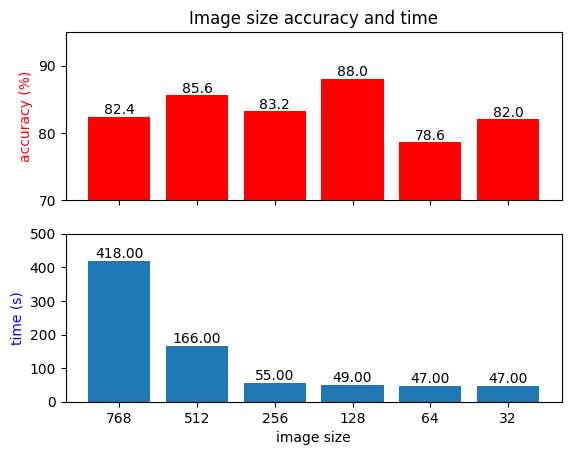

In [12]:
import matplotlib.pyplot as plt
import matplotlib.scale as scale
import pandas as pd

#load csv containing accuracies and time from above runs 
image_size_path = './csv/image_size_tuning/image_size_tuning_acc_time.csv'
df = pd.read_csv(image_size_path)
size, accuracy, time = df["size"].astype("str"), df.accuracy, df.time

fig, axs = plt.subplots(2, sharex = True)

axs[0].set_yticks([70,80,90])
axs[0].set_ylim([70,95])
axs[1].set_ylim([0, 500])

px1 = axs[1].bar(size, time)
px0 = axs[0].bar(size, accuracy, color = "red")

axs[0].bar_label(px0, fmt='%.1f')
axs[1].bar_label(px1, fmt='%.2f')

axs[0].set_title("Image size accuracy and time")
axs[1].set_xlabel('image size')
axs[0].set_ylabel('accuracy (%)', color = "red")
axs[1].set_ylabel('time (s)', color = "blue")

plt.show()


128 x 128 gives the best accuracy (88%) within a short amount of time (49s), hence we decided to go and test this dimension between greyscale and colored images. Typically colored images with 3 channels provide more the model with more information about the image as opposed to one channel, but at the direct cost of longer training times having to process larger dimension tensors. Our testing will reveal if the difference in accuracy is significant enough to warrant using 3 channels over 1.

In [4]:
# Build a cnn architecture for grayscaled and colored images. 

import torch 
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, color):
        super(SimpleCNN, self).__init__()
        self.color = color
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16*29*29, 64),
            nn.ReLU(),
            nn.Linear(64,5)
        )
        self.layer_g = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16*29*29, 64),
            nn.ReLU(),
            nn.Linear(64,5)
        )
        
    def forward(self, x):
        if self.color:
            x_c = self.layer(x)
            return x_c
        else:
            x_g = self.layer_g(x)
            return x_g

model = SimpleCNN(color=True) #by default, layer for colored images are selected. 
print(model)

SimpleCNN(
  (layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=13456, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
  (layer_g): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=13456, out_features=64, bias=True)
    (8): ReLU()
    (9

In [2]:
# load in dataset and transform them accordingly
import numpy as np 
import torch
import torchvision
from torchvision import transforms

# for color images, mean and std obtained above 
mean_c = np.array([0.7276, 0.5982, 0.8760])
std_c = np.array([0.1381, 0.1791, 0.0721])

transform_c = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

train_dataset_c = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_c)
test_dataset_c = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_c)

train_loader_c = torch.utils.data.DataLoader(train_dataset_c, batch_size=32, shuffle=True, num_workers=4)
test_loader_c = torch.utils.data.DataLoader(test_dataset_c, batch_size=32, shuffle=False, num_workers=4)

In [11]:
import time

# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining parameters for train function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = SimpleCNN(color=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_c = './trained_model/rgb_greyscale_tuning/model_rgb.pth'

start_time_c = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_c)
torch.save(model.state_dict(), model_path_c)
print('Model saved!')
print(f'Training time for colored 128x128 images: {(time.time() - start_time_c)}')

#Testing
print('Loading model')
model.load_state_dict(torch.load(model_path_c))
print('begin testing...')
acc = test(device, test_loader_c, model)
print(f'Accuracy of the network with colored 128x128 images: {acc} %')

##output
#Training time for colored 256x256 images: 46.8458411693573
#Accuracy of the network with colored 256x256 images: 85.8 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.3970608115196228
Epoch [1/5], Batch No: [125], Loss: 0.481218159198761
Epoch [2/5], Batch No: [100], Loss: 0.36479878425598145
Epoch [2/5], Batch No: [125], Loss: 0.4009583592414856
Epoch [3/5], Batch No: [100], Loss: 0.19853857159614563
Epoch [3/5], Batch No: [125], Loss: 0.2022189497947693
Epoch [4/5], Batch No: [100], Loss: 0.15906545519828796
Epoch [4/5], Batch No: [125], Loss: 0.09194484353065491
Epoch [5/5], Batch No: [100], Loss: 0.11858799308538437
Epoch [5/5], Batch No: [125], Loss: 0.1150529533624649
Model saved!
Training time for colored 128x128 images: 46.8458411693573
Loading model
begin testing...
Accuracy of the network with colored 128x128 images: 85.8 %


In [12]:
# load in dataset and transform them accordingly
import numpy as np 

# for color images, mean and std obtained above 
mean_g = np.array([0.6686])
std_g = np.array([0.1504])

transform_g = transforms.Compose([
    transforms.Resize(128),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_g), torch.Tensor(std_g))
])

train_dataset_g = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_g)
test_dataset_g = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_g)

train_loader_g = torch.utils.data.DataLoader(train_dataset_g, batch_size=32, shuffle=True, num_workers=4)
test_loader_g = torch.utils.data.DataLoader(test_dataset_g, batch_size=32, shuffle=False, num_workers=4)

# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
torch.manual_seed(123)

epochs = 5
loss_function = nn.CrossEntropyLoss()
model = SimpleCNN(color=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_g = './trained_model/rgb_greyscale_tuning/model_grey.pth'

start_time_g = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_g)
torch.save(model.state_dict(), model_path_g)
print('Model saved!')
print(f'Training time for grayscaled 128x128 images: {(time.time() - start_time_g)}')

#Testing
print('Loading model')
model.load_state_dict(torch.load(model_path_g))
print('begin testing...')
acc = test(device, test_loader_g, model)
print(f'Accuracy of the network with grayscaled 128x128 images: {acc} %')

##output
# Training time for grayscaled 256x256 images: 47.262062072753906
#Accuracy of the network with grayscaled 256x256 images: 84.2 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.5680825710296631
Epoch [1/5], Batch No: [125], Loss: 0.5306106805801392
Epoch [2/5], Batch No: [100], Loss: 0.4002307057380676
Epoch [2/5], Batch No: [125], Loss: 0.4576275944709778
Epoch [3/5], Batch No: [100], Loss: 0.3623161315917969
Epoch [3/5], Batch No: [125], Loss: 0.20099219679832458
Epoch [4/5], Batch No: [100], Loss: 0.17429007589817047
Epoch [4/5], Batch No: [125], Loss: 0.37145358324050903
Epoch [5/5], Batch No: [100], Loss: 0.1576310694217682
Epoch [5/5], Batch No: [125], Loss: 0.161721333861351
Model saved!
Training time for grayscaled 128x128 images: 47.262062072753906
Loading model
begin testing...
Accuracy of the network with grayscaled 128x128 images: 84.2 %


## Conclusion drawn above from Image Transformation
| Colour | Time (s) | Accuracy (%) 
| --- | --- | --- |
| rgb | 47 | 85.8 |
| greyscale | 47 | 84.2 |

Hence, it is conclusive that a colour image of 128 x 128 returns the best combination of accuracy and speed. 

# Step 2: Tuning CNN model architecture
The CNN model architecture is comprised of a series of consecutive convolution and pooling layers. As a trial, we will be comparing using 3 different architecture as listed below:
For simplicity, we will be calling 1 conv2d layer + 1 relu + 1 maxpooling2d as 1 convolution block. 

    1) CNN1: 1 convolutional block + 1 fully connected layer.
        input --> conv2d --> relu --> maxpooling2d --> fully connected --> output
    1) CNN2: 2 convolutional blocks + 2 fully connected layers
         input --> conv2d --> relu --> maxpooling2d --> conv2d --> relu --> maxpooling2d  --> fully connected --> relu -->fully connected --> output
    1) CNN3: 3 convolutional blocks + 3 fully connected layers
        input --> conv2d --> relu --> maxpooling2d --> conv2d --> relu --> maxpooling2d  --> conv2d --> relu --> maxpooling2d --> fully connected --> relu -->fully connected --> output




In [5]:
# build models
import torch 
import torch.nn as nn 

class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(6*62*62, 5)
        )
    def forward(self, x):
        x = self.layer(x)
        return x 

class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(16*29*29, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
    def forward(self, x):
        x = self.layer(x)
        return x 

class CNN_3(nn.Module):
    def __init__(self):
        super(CNN_3, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(32*12*12, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,5)
        )
    def forward(self, x):
        x = self.layer(x)
        return x 

model1 = CNN_1()
print(model1)

model2=CNN_2()
print(model2)

model3 = CNN_3()
print(model3)

CNN_1(
  (layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=23064, out_features=5, bias=True)
  )
)
CNN_2(
  (layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=13456, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
)
CNN_3(
  (layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [10]:
# load data in. We will be using the transformation method that we found out previously 

# load in dataset and transform them accordingly
import numpy as np 
import torchvision
import torchvision.transforms as transforms

# for color images, mean and std obtained above 
mean_c = np.array([0.7276, 0.5982, 0.8760])
std_c = np.array([0.1381, 0.1791, 0.0721])

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

train_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [11]:
import time

In [12]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining arguments for train function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = CNN_1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_cnn1 = './trained_model/conv_blocks_layers_tuning/model_1block_1layer.pth'

start_time_cnn1 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader)
torch.save(model.state_dict(), model_path_cnn1)
print('Model saved!')
print(f'Training time for cnn1: {(time.time() - start_time_cnn1)}')

#Testing
print('Loading model')
model.load_state_dict(torch.load(model_path_cnn1))
print('begin testing...')
acc = test(device, test_loader, model)
print(f'Accuracy of the network, cnn1: {acc} %')

#output
#Training time for cnn1: 48.44683122634888
#Accuracy of the network, cnn1: 81.0 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.8579059839248657
Epoch [1/5], Batch No: [125], Loss: 0.4389542043209076
Epoch [2/5], Batch No: [100], Loss: 0.38410866260528564
Epoch [2/5], Batch No: [125], Loss: 0.10127340257167816
Epoch [3/5], Batch No: [100], Loss: 0.1608918309211731
Epoch [3/5], Batch No: [125], Loss: 0.3683255910873413
Epoch [4/5], Batch No: [100], Loss: 0.2286471575498581
Epoch [4/5], Batch No: [125], Loss: 0.4573556184768677
Epoch [5/5], Batch No: [100], Loss: 0.04356495290994644
Epoch [5/5], Batch No: [125], Loss: 0.06691357493400574
Model saved!
Training time for cnn1: 48.44683122634888
Loading model
begin testing...
Accuracy of the network, cnn1: 81.0 %


In [13]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining args for train function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = CNN_2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_cnn2 = './trained_model/conv_blocks_layers_tuning//model_2blocks_2layers.pth'

# training
start_time_cnn2 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader)
torch.save(model.state_dict(), model_path_cnn2)
print('Model saved!')
print(f'Training time for cnn2: {(time.time() - start_time_cnn2)}')

#Testing
print('Loading model')
model.load_state_dict(torch.load(model_path_cnn2))
print('begin testing...')
acc = test(device, test_loader, model)
print(f'Accuracy of the network, cnn2: {acc} %')

#output
# Training time for cnn2: 49.357346057891846
# Accuracy of the network, cnn2: 86 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.38204121589660645
Epoch [1/5], Batch No: [125], Loss: 0.36368685960769653
Epoch [2/5], Batch No: [100], Loss: 0.3968985080718994
Epoch [2/5], Batch No: [125], Loss: 0.30707061290740967
Epoch [3/5], Batch No: [100], Loss: 0.2615492045879364
Epoch [3/5], Batch No: [125], Loss: 0.10216230154037476
Epoch [4/5], Batch No: [100], Loss: 0.10225407034158707
Epoch [4/5], Batch No: [125], Loss: 0.37571877241134644
Epoch [5/5], Batch No: [100], Loss: 0.033302221447229385
Epoch [5/5], Batch No: [125], Loss: 0.11121952533721924
Model saved!
Training time for cnn2: 49.357346057891846
Loading model
begin testing...
Accuracy of the network, cnn2: 86.0 %


In [14]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining args for train function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = CNN_3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_cnn3 = './trained_model/conv_blocks_layers_tuning/model_3blocks_3layers.pth'

# training
start_time_cnn3 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader)
torch.save(model.state_dict(), model_path_cnn3)
print('Model saved!')
print(f'Training time for cnn3: {(time.time() - start_time_cnn3)}')

#Testing
print('Loading model')
model.load_state_dict(torch.load(model_path_cnn3))
print('begin testing...')
acc = test(device, test_loader, model)
print(f'Accuracy of the network, cnn3: {acc} %')

#output
# Training time for cnn2: 57.041712045669556
# Accuracy of the network, cnn2: 87.8 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.8736829161643982
Epoch [1/5], Batch No: [125], Loss: 0.48351454734802246
Epoch [2/5], Batch No: [100], Loss: 0.5685288906097412
Epoch [2/5], Batch No: [125], Loss: 0.5958327054977417
Epoch [3/5], Batch No: [100], Loss: 0.3501506447792053
Epoch [3/5], Batch No: [125], Loss: 0.4895098805427551
Epoch [4/5], Batch No: [100], Loss: 0.51751309633255
Epoch [4/5], Batch No: [125], Loss: 0.28051498532295227
Epoch [5/5], Batch No: [100], Loss: 0.23935548961162567
Epoch [5/5], Batch No: [125], Loss: 0.19201964139938354
Model saved!
Training time for cnn3: 48.107027769088745
Loading model
begin testing...
Accuracy of the network, cnn3: 82.8 %


| Num of Layers | Time (s) | Accuracy (%) 
| --- | --- | --- |
| 1 | 48 | 81.0 |
| 2 | 49 | 86.0 |
| 3 | 48 | 82.8 |

Given that cnn2 has the highest accuracy, we decided to go with that architecture. However, we would are also interested whether putting different number of blocks and layers will affect the accuracy. Hence, 2 more similar architecture as listed below, were created. cnn4 comprises 3 convolutional blocks and 2 dense layers while cnn5 comprises 2 convolutional blocks and 3 dense layers.

In [15]:
# more models 

class CNN_4(nn.Module):
    def __init__(self):
        super(CNN_4, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(32*12*12, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
    def forward(self, x):
        x = self.layer(x)
        return x 

class CNN_5(nn.Module):
    def __init__(self):
        super(CNN_5, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(16*29*29, 128),
            nn.ReLU(),
            nn.Linear(64,5)
        )
    def forward(self, x):
        x = self.layer(x)
        return x 

model4 = CNN_4()
print(model4)

model5 = CNN_5()
print(model5)

CNN_4(
  (layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=4608, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=5, bias=True)
  )
)
CNN_5(
  (layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, pad

In [16]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining args for train function
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = CNN_4().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_cnn4 = './trained_model/conv_blocks_layers_tuning/model_3blocks_2layers.pth'

# training
start_time_cnn4 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader)
torch.save(model.state_dict(), model_path_cnn4)
print('Model saved!')
print(f'Training time for cnn4: {(time.time() - start_time_cnn4)}')

# testing
print('Loading model')
model.load_state_dict(torch.load(model_path_cnn4))
print('begin testing...')
acc = test(device, test_loader, model)
print(f'Accuracy of the network, cnn4: {acc} %')

#output
#Training time for cnn3: 50.65544891357422
#Accuracy of the network, cnn4: 85.2 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.6114381551742554
Epoch [1/5], Batch No: [125], Loss: 0.43969035148620605
Epoch [2/5], Batch No: [100], Loss: 0.5841302275657654
Epoch [2/5], Batch No: [125], Loss: 0.41191941499710083
Epoch [3/5], Batch No: [100], Loss: 0.30548882484436035
Epoch [3/5], Batch No: [125], Loss: 0.2482708990573883
Epoch [4/5], Batch No: [100], Loss: 0.3879404067993164
Epoch [4/5], Batch No: [125], Loss: 0.2354583740234375
Epoch [5/5], Batch No: [100], Loss: 0.1116444319486618
Epoch [5/5], Batch No: [125], Loss: 0.2237231433391571
Model saved!
Training time for cnn4: 50.65544891357422
Loading model
begin testing...
Accuracy of the network, cnn4: 85.2 %


In [17]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding 
torch.manual_seed(123)

# defining args for training
epochs = 5
loss_function = nn.CrossEntropyLoss()
model = CNN_5().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_cnn5 = './trained_model/conv_blocks_layers_tuning/model_2blocks_3layers.pth'

# training
start_time_cnn5 = time.time()
print('Starting training...')
model = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader)
torch.save(model.state_dict(), model_path_cnn5)
print('Model saved!')
print(f'Training time for cnn5: {(time.time() - start_time_cnn5)}')

# testing
print('Loading model')
model.load_state_dict(torch.load(model_path_cnn5))
print('begin testing...')
acc = test(device, test_loader, model)
print(f'Accuracy of the network, cnn5: {acc} %')

#output
# Training time for cnn5: 47.930099964141846
# Accuracy of the network, cnn5: 82.2 %

Using device: mps
Starting training...
Epoch [1/5], Batch No: [100], Loss: 0.46073463559150696
Epoch [1/5], Batch No: [125], Loss: 0.21983854472637177
Epoch [2/5], Batch No: [100], Loss: 0.31040674448013306
Epoch [2/5], Batch No: [125], Loss: 0.5477465391159058
Epoch [3/5], Batch No: [100], Loss: 0.23659318685531616
Epoch [3/5], Batch No: [125], Loss: 0.33972615003585815
Epoch [4/5], Batch No: [100], Loss: 0.1850094348192215
Epoch [4/5], Batch No: [125], Loss: 0.09443926066160202
Epoch [5/5], Batch No: [100], Loss: 0.06936082243919373
Epoch [5/5], Batch No: [125], Loss: 0.0485096350312233
Model saved!
Training time for cnn5: 47.930099964141846
Loading model
begin testing...
Accuracy of the network, cnn5: 82.2 %


## Conclusion for layers in CNN model architecture 

| Model | Time (s) | Accuracy (%) 
| --- | --- | --- |
| cnn1 | 48 | 81.0 |
| cnn2 | 49 | 86.0 |
| cnn3 | 48 | 82.8 |
| cnn4 | 50 | 85.2 |
| cnn5 | 48 | 82.2 |

CNN_2 shows the best accuracy with a relatively short amount of training time. As such, the architecture for cnn2 will be used to develop the model further.

# Step 3: Tuning kernel size 
Kernel size refers to the filter size which is applied to the image and also reduces the image dimensionality over time for each layer. We are interested in a range of dimensions to find out which will give the best representation of the image and hence decrease loss. Kernel sizes of 3 x 3, 4 x 4 and 5 x 5 will be analysed.

In this part, we will be running the model using training data and validation data over 100 epochs. The graphs for validation and training loss will be plotted to identify if they diverge or converge from one another. Divergence of the validation loss curve is an indication of overfitting of the model to the training dataset, while a converging curve shows that the validation loss continues to be minimised over each iteration. At the end, the model with the lowest validation loss is saved out of the 100 epochs using a callback.

In [24]:
# load in dataset with transformation
import numpy as np 
import torchvision
import torchvision.transforms as transforms

# for color images, mean and std obtained above 
mean_c = np.array([0.7276, 0.5982, 0.8760])
std_c = np.array([0.1381, 0.1791, 0.0721])

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

train_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/val', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [25]:
# model architecture, kernel size =  (3,3), (4,4), (5,5)

class CNN_kernel(nn.Module):
    def __init__(self, kernel_size):
        super(CNN_kernel, self).__init__()
        self.layer3 = nn.Sequential(
            nn.Conv2d(3,6,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(16*30*30, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(3,6,4),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,4),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(16*29*29, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(16*29*29, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.kernel_size = kernel_size
    def forward(self, x):
        if self.kernel_size == 3:
            x_3 = self.layer3(x)
            return x_3 
        elif self.kernel_size == 4:
            x_4 = self.layer4(x)
            return x_4
        elif self.kernel_size == 5:
            x_5 = self.layer5(x)
            return x_5

model = CNN_kernel(3)
print(model)

CNN_kernel(
  (layer3): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=14400, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
  (layer4): Sequential(
    (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=13456, out_features=64, bias=True)
    (8): ReLU()
    (

In [26]:
# training and validating helper function 

# Train
def train_no_early_stop(device, model, epochs, optimizer, loss_function, 
                            train_loader, val_loader):   
    train_loss = []
    val_loss = []  
                       
    for epoch in range(epochs):
        model.train()
        total_val_loss = 0 
        batch_train_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            label = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            output = model(images)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()

            batch_train_loss += loss.item()
            
            # Show progress
            if (batch_idx+1)%100 == 0 or (batch_idx+1)==len(train_loader): 
                print (f'Epoch [{epoch+1}/{epochs}], Batch No: [{batch_idx+1}], Loss: {loss.item()}')
            
        avg_batch_train_loss = batch_train_loss/len(train_loader)
        train_loss.append(avg_batch_train_loss)

        # check validation loss
        print('Validating...')
        current_val_loss = validation(model, device, val_loader, loss_function)
        print('The Current Loss:', current_val_loss)
        val_loss.append(current_val_loss)
    
    return model, train_loss, val_loss

# validation
def validation(model, device, valid_loader, loss_function):
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = loss_function(output, labels)
            loss_total += loss.item()

    return loss_total / len(valid_loader)

Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 0.35772547125816345
Epoch [1/100], Batch No: [125], Loss: 0.33043020963668823
Validating...
The Current Loss: 0.4365643309429288
Epoch [2/100], Batch No: [100], Loss: 0.20881034433841705
Epoch [2/100], Batch No: [125], Loss: 0.25290048122406006
Validating...
The Current Loss: 0.3572642159415409
Epoch [3/100], Batch No: [100], Loss: 0.11603504419326782
Epoch [3/100], Batch No: [125], Loss: 0.10660896450281143
Validating...
The Current Loss: 0.2674061395227909
Epoch [4/100], Batch No: [100], Loss: 0.1581675410270691
Epoch [4/100], Batch No: [125], Loss: 0.09915632009506226
Validating...
The Current Loss: 0.2628471702337265
Epoch [5/100], Batch No: [100], Loss: 0.06754691898822784
Epoch [5/100], Batch No: [125], Loss: 0.0588197261095047
Validating...
The Current Loss: 0.3053774363361299
Epoch [6/100], Batch No: [100], Loss: 0.021928973495960236
Epoch [6/100], Batch No: [125], Loss: 0.00763732334598

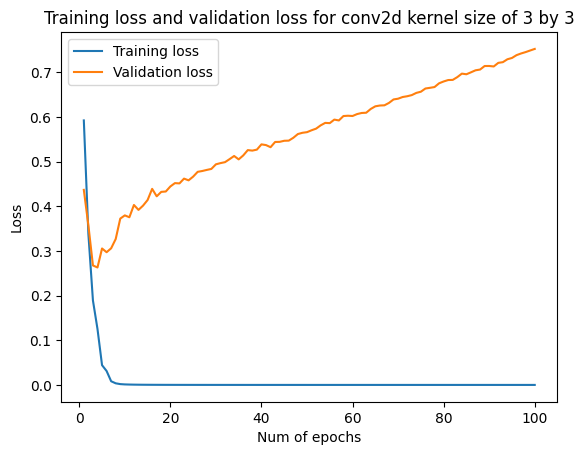

In [27]:
import matplotlib.pyplot as plt 
import pandas as pd 

# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN_kernel(3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_kernel3 = './trained_model/conv_kernel_tuning//model_kernel_3x3.pth'

# training and validating
print('Starting training and validating...')
model, train_loss_3, val_loss_3, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader, val_loader)
torch.save(model.state_dict(), model_path_kernel3)
print('Model saved!')

# plotting of training loss and val loss
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_3, label='Training loss')
plt.plot(x, val_loss_3, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss for conv2d kernel size of 3 by 3')
plt.savefig('./images/conv_kernel_tuning/training_and_val_loss_kernel_3x3.png')
plt.show()

# saving training loss and val loss as csv 
dict = {'train_loss': train_loss_3, 'val_loss_' : val_loss_3}
df = pd.DataFrame(dict)
df.to_csv('./csv/conv_kernel_tuning/training_and_val_loss_kernel_3x3.csv')

#18m 15s

Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 0.42419105768203735
Epoch [1/100], Batch No: [125], Loss: 0.4024391770362854
Validating...
The Current Loss: 0.4023437211290002
Epoch [2/100], Batch No: [100], Loss: 0.27034318447113037
Epoch [2/100], Batch No: [125], Loss: 0.3464336693286896
Validating...
The Current Loss: 0.37232266389764845
Epoch [3/100], Batch No: [100], Loss: 0.17103704810142517
Epoch [3/100], Batch No: [125], Loss: 0.12631314992904663
Validating...
The Current Loss: 0.389857726637274
Epoch [4/100], Batch No: [100], Loss: 0.08256523311138153
Epoch [4/100], Batch No: [125], Loss: 0.10829731822013855
Validating...
The Current Loss: 0.344214394222945
Epoch [5/100], Batch No: [100], Loss: 0.06122489273548126
Epoch [5/100], Batch No: [125], Loss: 0.31882864236831665
Validating...
The Current Loss: 0.4248131583444774
Epoch [6/100], Batch No: [100], Loss: 0.030240263789892197
Epoch [6/100], Batch No: [125], Loss: 0.014038993045687

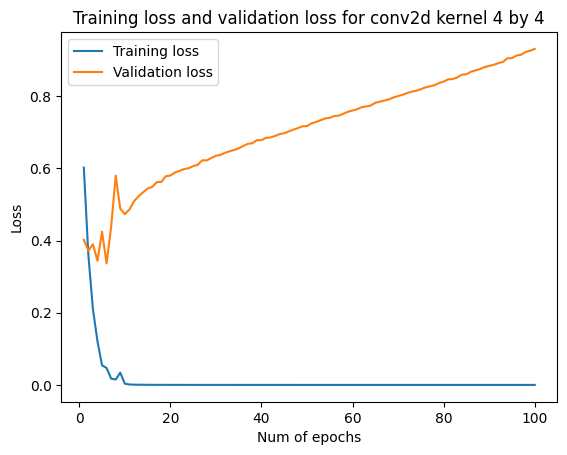

In [28]:
import matplotlib.pyplot as plt 

# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# sedding
torch.manual_seed(123)

# defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN_kernel(4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_kernel4 = './trained_model/conv_kernel_tuning/model_kernel_4x4.pth'

# training and validating
print('Starting training and validating...')
model, train_loss_4, val_loss_4, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader, val_loader)
torch.save(model.state_dict(), model_path_kernel4)
print('Model saved!')

# plot training loss and val loss
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_4, label='Training loss')
plt.plot(x, val_loss_4, label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.title('Training loss and validation loss for conv2d kernel 4 by 4')
plt.savefig('./images/conv_kernel_tuning/training_val_loss_kernel_4x4.png')
plt.show()

dict = {'train_loss': train_loss_4, 'val_loss_' : val_loss_4}
df = pd.DataFrame(dict)
df.to_csv('./csv/conv_kernel_tuning/training_val_loss_kernel_4x4.csv')

#20m 55s

Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 0.4655757546424866
Epoch [1/100], Batch No: [125], Loss: 0.3316245973110199
Validating...
The Current Loss: 0.453182490542531
Epoch [2/100], Batch No: [100], Loss: 0.34015390276908875
Epoch [2/100], Batch No: [125], Loss: 0.334405779838562
Validating...
The Current Loss: 0.38535582972690463
Epoch [3/100], Batch No: [100], Loss: 0.22086548805236816
Epoch [3/100], Batch No: [125], Loss: 0.16008241474628448
Validating...
The Current Loss: 0.32248380361124873
Epoch [4/100], Batch No: [100], Loss: 0.23036879301071167
Epoch [4/100], Batch No: [125], Loss: 0.14819180965423584
Validating...
The Current Loss: 0.31591651611961424
Epoch [5/100], Batch No: [100], Loss: 0.10086359083652496
Epoch [5/100], Batch No: [125], Loss: 0.057989805936813354
Validating...
The Current Loss: 0.3008816835936159
Epoch [6/100], Batch No: [100], Loss: 0.09129533171653748
Epoch [6/100], Batch No: [125], Loss: 0.02141039259731

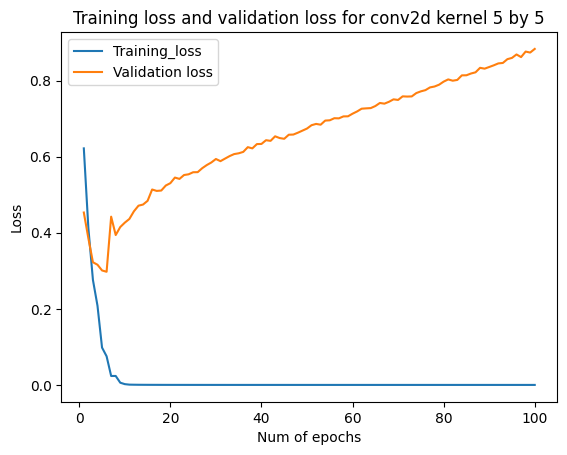

In [29]:
import matplotlib.pyplot as plt 

# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN_kernel(5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_kernel5 = './trained_model/conv_kernel_tuning/model_kernel_5x5.pth'

# training and validating 
print('Starting training and validating...')
model, train_loss_5, val_loss_5, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader, val_loader)
torch.save(model.state_dict(), model_path_kernel5)
print('Model saved!')

# plotting training and validation losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_5, label='Training_loss')
plt.plot(x, val_loss_5, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.title('Training loss and validation loss for conv2d kernel 5 by 5')
plt.legend(loc='best')
plt.savefig('./images/conv_kernel_tuning//training_val_loss_kernel_5x5.png')
plt.show()

# saving losses to csv file
dict = {'train_loss': train_loss_5, 'val_loss_' : val_loss_5}
df = pd.DataFrame(dict)
df.to_csv('./csv/conv_kernel_tuning//training_val_loss_kernel_5x5.csv')


# Comparison between kernel sizes
Plot of validation losses and training losses of different kernel sizes are plotted together to see if they can provide any insights to how model is trained.

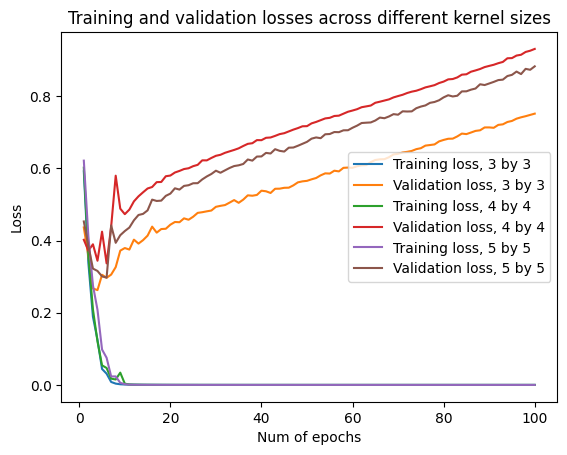

In [32]:
# full sized version
# zoomed version
x = [i for i in range(1, 101)]
for i in [3,4,5]:
    data_path = f'./csv/conv_kernel_tuning/training_val_loss_kernel_{i}x{i}.csv'
    df = pd.read_csv(data_path)
    training_loss, val_loss = df.train_loss, df.val_loss_
    plt.plot(x,training_loss, label = f'Training loss, {i} by {i}')
    plt.plot(x, val_loss, label=f"Validation loss, {i} by {i}")

plt.xlabel("Num of epochs")
plt.ylabel("Loss")
plt.title('Training and validation losses across different kernel sizes')
plt.legend(loc='best')
plt.savefig('./images/conv_kernel_tuning/loss_comparison_for_different_kernel_size.png')

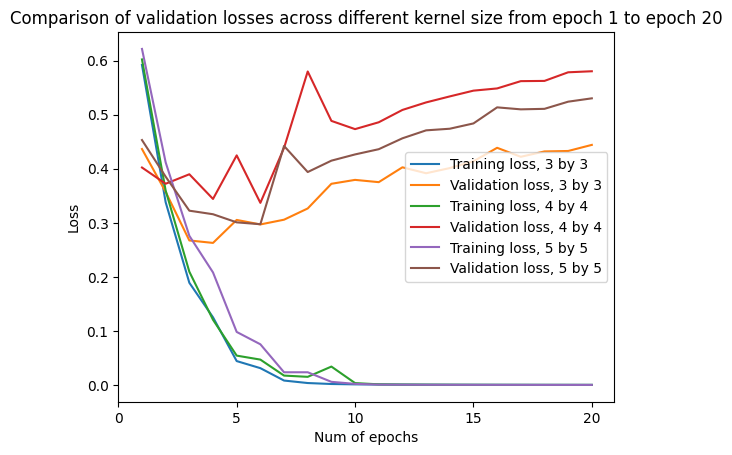

In [8]:
# zoomed version
import pandas as pd 
import matplotlib.pyplot as plt 

x_trunc = [i for i in range(1,21)]
for i in [3,4,5]:
    data_path = f'./csv/conv_kernel_tuning/training_val_loss_kernel_{i}x{i}.csv'
    df = pd.read_csv(data_path)
    training_loss, val_loss = df.train_loss, df.val_loss_
    plt.plot(x_trunc, training_loss[:20], label = f'Training loss, {i} by {i}')
    plt.plot(x_trunc, val_loss[:20], label = f'Validation loss, {i} by {i}')

plt.xlabel("Num of epochs")
plt.xticks([i for i in range(0,21,5)])
plt.ylabel("Loss")
plt.title('Comparison of validation losses across different kernel size from epoch 1 to epoch 20')
plt.legend(loc='best')
plt.savefig('./images/conv_kernel_tuning/loss_comparison_for_different_kernel_size_zoomed.png')

## Conclusion from kernel size tuning

| Kernel size | Loss
| --- | --- | 
| 3 x 3 | 0.297 |
| 4 x 4 | 0.337 |
| 5 x 5 | 0.301 |

3 plots were plotted each representing a kernel size. Kernel size of 3 by 3 shows the lowest validation loss and in general, a range of lower loss throughout 100 epochs. In addition, from the plot above, 3 by 3 kernel validation loss takes a longer time before overfitting starts taking place. As such, we will proceed with a convolution filter kernel size of 3 by 3 in the next section of our hyperparamter tuning. 

# Step 4: Maxpooling filter size tuning 
Max pooling is applied to the feature map to extract the maximum number that is fitted inside the 2d array of a specified kernel size. In image classification, max pooling can be used as an equated as a process to extract the most prominent part of the image. Generally the smaller the max pooling kernel size, the better extraction of features from the image. The same rationale that was used on filter kernel size tuning can be used here. We will proceed with the following dimension of 3 by 3, 4 by 4 and 5 by 5. As with before, only the max pooling kernel size is varied while other hyperparameters are kept constant.

In [8]:
#build models
# model architecture, max pooling kernal size =  (3,3), (4,4), (5,5)

class CNN_kernel_MP(nn.Module):
    def __init__(self, MP_kernel_size):
        super(CNN_kernel_MP, self).__init__()
        self.layer3 = nn.Sequential(
            nn.Conv2d(3,6,3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(6,16,3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Flatten(),
            nn.Linear(16*29*29, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(3,6,3),
            nn.ReLU(),
            nn.MaxPool2d(4,2),
            nn.Conv2d(6,16,3),
            nn.ReLU(),
            nn.MaxPool2d(4,2),
            nn.Flatten(),
            nn.Linear(16*29*29, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(3,6,3),
            nn.ReLU(),
            nn.MaxPool2d(5,2),
            nn.Conv2d(6,16,3),
            nn.ReLU(),
            nn.MaxPool2d(5,2),
            nn.Flatten(),
            nn.Linear(16*28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.MP_kernel_size = MP_kernel_size
    def forward(self, x):
        if self.MP_kernel_size == 3:
            x_3 = self.layer3(x)
            return x_3 
        elif self.MP_kernel_size == 4:
            x_4 = self.layer4(x)
            return x_4
        elif self.MP_kernel_size == 5:
            x_5 = self.layer5(x)
            return x_5

model = CNN_kernel_MP(3)
print(model)

CNN_kernel_MP(
  (layer3): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=13456, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
  (layer4): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=13456, out_features=64, bias=True)
    (8): ReLU()
  

In [9]:
#load dataset 
# load in dataset with transformation
import numpy as np 
import torchvision
import torchvision.transforms as transforms

# for color images, mean and std obtained above 
mean_c = np.array([0.7276, 0.5982, 0.8760])
std_c = np.array([0.1381, 0.1791, 0.0721])

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

train_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/val', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [6]:
# training and validating 

# Train
def train_no_early_stop(device, model, epochs, optimizer, loss_function, 
                            train_loader, val_loader):   
    train_loss = []
    val_loss = []  
                       
    for epoch in range(epochs):
        model.train()
        total_val_loss = 0 
        batch_train_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            label = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            output = model(images)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()

            batch_train_loss += loss.item()
            
            # Show progress
            if (batch_idx+1)%100 == 0 or (batch_idx+1)==len(train_loader): 
                print (f'Epoch [{epoch+1}/{epochs}], Batch No: [{batch_idx+1}], Loss: {loss.item()}')
            
        avg_batch_train_loss = batch_train_loss/len(train_loader)
        train_loss.append(avg_batch_train_loss)

        # check validation loss
        print('Validating...')
        current_val_loss = validation(model, device, val_loader, loss_function)
        print('The Current Loss:', current_val_loss)
        val_loss.append(current_val_loss)
    
    return model, train_loss, val_loss

def validation(model, device, valid_loader, loss_function):
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = loss_function(output, labels)
            loss_total += loss.item()

    return loss_total / len(valid_loader)

Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 0.34000176191329956
Epoch [1/100], Batch No: [125], Loss: 0.5502285957336426
Validating...
The Current Loss: 0.5043395552784204
Epoch [2/100], Batch No: [100], Loss: 0.5105823278427124
Epoch [2/100], Batch No: [125], Loss: 0.40606001019477844
Validating...
The Current Loss: 0.34460731502622366
Epoch [3/100], Batch No: [100], Loss: 0.1236443966627121
Epoch [3/100], Batch No: [125], Loss: 0.32572999596595764
Validating...
The Current Loss: 0.31355478358455
Epoch [4/100], Batch No: [100], Loss: 0.08790308237075806
Epoch [4/100], Batch No: [125], Loss: 0.11165553331375122
Validating...
The Current Loss: 0.2748951269313693
Epoch [5/100], Batch No: [100], Loss: 0.059401631355285645
Epoch [5/100], Batch No: [125], Loss: 0.08199853450059891
Validating...
The Current Loss: 0.25129358656704426
Epoch [6/100], Batch No: [100], Loss: 0.11582449078559875
Epoch [6/100], Batch No: [125], Loss: 0.049427751451730

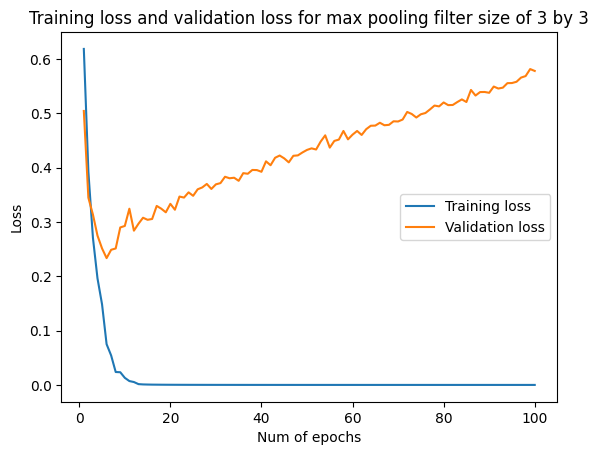

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# seeding
torch.manual_seed(123)

# defining args for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN_kernel_MP(3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_MP3= './trained_model/max_pooling_filter_size_tuning/model_MP_3x3.pth'

# training and validating
print('Starting training and validating...')
model, train_loss_MP3, val_loss_MP3, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader, val_loader)
torch.save(model.state_dict(), model_path_MP3)
print('Model saved!')

# plotting training and validation losses 
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_MP3, label='Training loss')
plt.plot(x, val_loss_MP3, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss for max pooling filter size of 3 by 3')
plt.savefig('./images/max_pooling_filter_size_tuning/training_val_loss_max_pooling_kernel_3x3.png')
plt.show()

# saving training and validation losses
dict = {'train_loss': train_loss_MP3, 'val_loss_' : val_loss_MP3}
df = pd.DataFrame(dict)
df.to_csv('./csv/max_pooling_filter_size_tuning/training_val_loss_max_pooling_kernel_3x3.csv')

Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 0.2833925485610962
Epoch [1/100], Batch No: [125], Loss: 0.694267988204956
Validating...
The Current Loss: 0.5055553116835654
Epoch [2/100], Batch No: [100], Loss: 0.3425540626049042
Epoch [2/100], Batch No: [125], Loss: 0.18252062797546387
Validating...
The Current Loss: 0.3244660869240761
Epoch [3/100], Batch No: [100], Loss: 0.11784189939498901
Epoch [3/100], Batch No: [125], Loss: 0.19489029049873352
Validating...
The Current Loss: 0.310878399759531
Epoch [4/100], Batch No: [100], Loss: 0.06528285145759583
Epoch [4/100], Batch No: [125], Loss: 0.09262803196907043
Validating...
The Current Loss: 0.22518583573400974
Epoch [5/100], Batch No: [100], Loss: 0.01872253604233265
Epoch [5/100], Batch No: [125], Loss: 0.04021342098712921
Validating...
The Current Loss: 0.38430309906834736
Epoch [6/100], Batch No: [100], Loss: 0.02556110918521881
Epoch [6/100], Batch No: [125], Loss: 0.0329777598381042

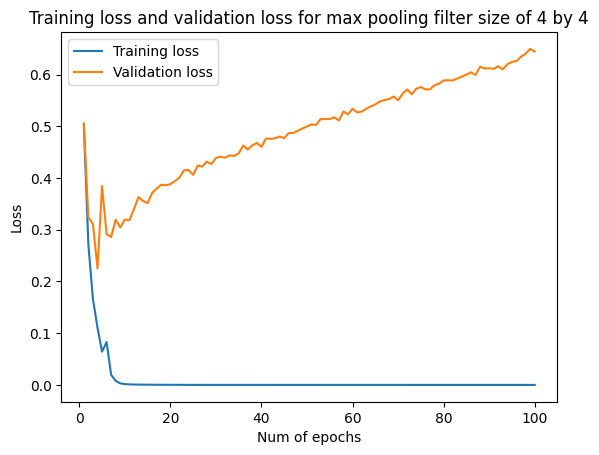

In [13]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

#defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN_kernel_MP(4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_MP4= './trained_model/max_pooling_filter_size_tuning/model_MP_4x4.pth'

#training and validating
print('Starting training and validating...')
model, train_loss_MP4, val_loss_MP4, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader, val_loader)
torch.save(model.state_dict(), model_path_MP4)
print('Model saved!')

#plotting training and validating losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_MP4, label='Training loss')
plt.plot(x, val_loss_MP4, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss for max pooling filter size of 4 by 4')
plt.savefig('./images/max_pooling_filter_size_tuning/training_val_loss_max_pooling_kernel_4x4.png')
plt.show()

#savinig training and validation losses as csv
dict = {'train_loss': train_loss_MP4, 'val_loss_' : val_loss_MP4}
df = pd.DataFrame(dict)
df.to_csv('./csv/max_pooling_filter_size_tuning/training_val_loss_max_pooling_kernel_4x4.csv')

Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 0.3934868276119232
Epoch [1/100], Batch No: [125], Loss: 0.6282872557640076
Validating...
The Current Loss: 0.5198494652286172
Epoch [2/100], Batch No: [100], Loss: 0.47531917691230774
Epoch [2/100], Batch No: [125], Loss: 0.50004643201828
Validating...
The Current Loss: 0.42058482486754656
Epoch [3/100], Batch No: [100], Loss: 0.13902682065963745
Epoch [3/100], Batch No: [125], Loss: 0.34089502692222595
Validating...
The Current Loss: 0.315164846368134
Epoch [4/100], Batch No: [100], Loss: 0.09006258845329285
Epoch [4/100], Batch No: [125], Loss: 0.27540019154548645
Validating...
The Current Loss: 0.32551948400214314
Epoch [5/100], Batch No: [100], Loss: 0.11846914887428284
Epoch [5/100], Batch No: [125], Loss: 0.19173407554626465
Validating...
The Current Loss: 0.2564388853497803
Epoch [6/100], Batch No: [100], Loss: 0.29868513345718384
Epoch [6/100], Batch No: [125], Loss: 0.1479501724243164


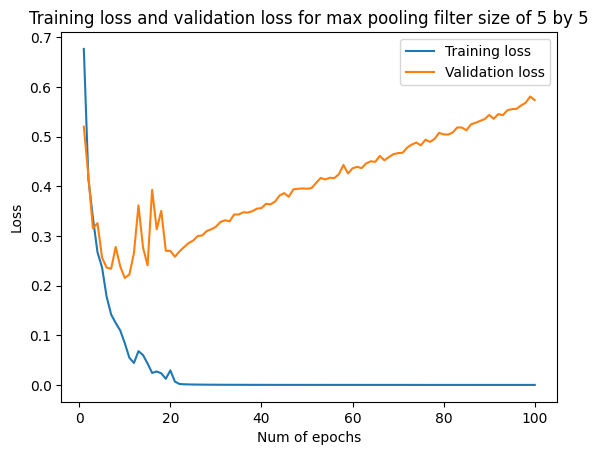

In [14]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

#defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN_kernel_MP(5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_MP5= './trained_model/max_pooling_filter_size_tuning/model_MP_5x5.pth'

# training and validating
print('Starting training and validating...')
model, train_loss_MP5, val_loss_MP5, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader, val_loader)
torch.save(model.state_dict(), model_path_MP5)
print('Model saved!')

#plotting training and validation losses 
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_MP5, label='Training loss')
plt.plot(x, val_loss_MP5, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss for max pooling filter size of 5 by 5')
plt.savefig('./images/max_pooling_filter_size_tuning/training_val_loss_max_pooling_kernel_5x5.png')
plt.show()

#saving losses as csv 
dict = {'train_loss': train_loss_MP5, 'val_loss_' : val_loss_MP5}
df = pd.DataFrame(dict)
df.to_csv('./csv/max_pooling_filter_size_tuning/training_val_loss_max_pooling_kernel_5x5.csv')

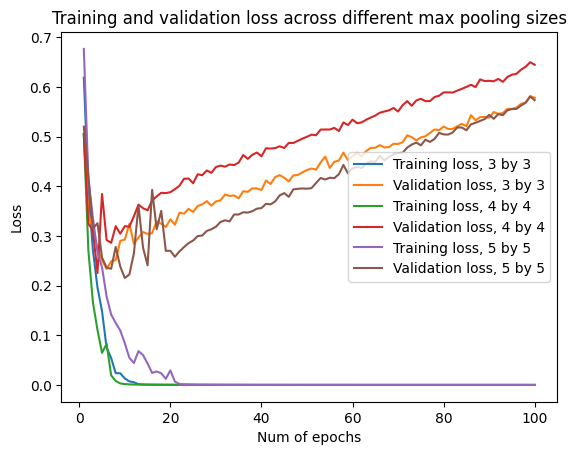

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

x = [i for i in range(1,101)]
for i in [3,4,5]:
    data_path = f'./csv/max_pooling_filter_size_tuning/training_val_loss_max_pooling_kernel_{i}x{i}.csv'
    df = pd.read_csv(data_path)
    train_loss, val_loss = df.train_loss, df.val_loss_
    plt.plot(x, train_loss, label=f'Training loss, {i} by {i}')
    plt.plot(x, val_loss, label=f'Validation loss, {i} by {i}')

plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training and validation loss across different max pooling sizes')
plt.savefig('./images/max_pooling_filter_size_tuning/Training_and_valdiation_losses_across_different_max_pooling_sizes.png')

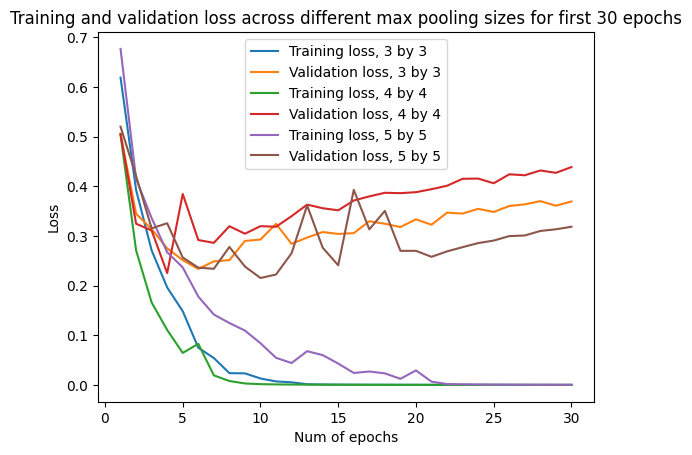

In [19]:
x = [i for i in range(1,31)]
for i in [3,4,5]:
    data_path = f'./csv/max_pooling_filter_size_tuning/training_val_loss_max_pooling_kernel_{i}x{i}.csv'
    df = pd.read_csv(data_path)
    train_loss, val_loss = df.train_loss, df.val_loss_
    plt.plot(x, train_loss[:30], label=f'Training loss, {i} by {i}')
    plt.plot(x, val_loss[:30], label=f'Validation loss, {i} by {i}')

plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training and validation loss across different max pooling sizes for first 30 epochs')
plt.savefig('./images/max_pooling_filter_size_tuning/Training_and_valdiation_losses_across_different_max_pooling_sizes_zoomed.png')

## Conclusion drawn from above 

| Maxpooling kernel size | Train duration | Loss
| --- | --- | --- |
| 3 x 3 | 18m 46s | 0.2334 |
| 4 x 4 | 18m 50s | 0.2251 |
| 5 x 5 | 18m 20s | 0.2152 |

The training results show that the 5 x 5 filter gives the lowest possible cost. It is also noted that 5 x 5 filter size takes more epoch for its training loss to remain constant.

Based on the 3 plots of training and validation loss by epoch, it is evident that validation loss is still significantly higher than the training loss. 

Some overfitting pattern is observed and there is a need to generalise the dataset even more to reduce this occurrence and make the model more robust.

# Step 5: Reducing overfitting

#### Image augmentation
Randomness into the training dataset to improve the fitting of model. One way this can be achieved is by flipping randomly selected images from the training data horizontally or vertically with a certain preset probability. For this optimisation step, a vertical flip will be performed at random with the probability `x` of occurrence where `x = [0.2, 0.5, 0.8]`, followed by a chance of a horizontal flip with the same probability of occurrence.

#### Learning rate optimisation
Following the first round of introducing randomised flipping of images in the training set, validation loss plot showed large oscillations in value as compared to the training loss. This could be due to the learning rate being too high and hence unable to reach the minimum value 
Hence, another method of optimisation has to be introduced to decrease the learning rate by in decreasing 10 folds to observe the difference in validation loss oscillation and to achieve a rate of gradient change that is not too extreme between consecutive epochs.


In [20]:
# for image transformation

# load dataset 
# load in dataset with transformation
import numpy as np 
import torchvision
import torchvision.transforms as transforms

# for color images, mean and std obtained above 
mean_c = np.array([0.7276, 0.5982, 0.8760])
std_c = np.array([0.1381, 0.1791, 0.0721])

transform_train_p20 = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomHorizontalFlip(0.2),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_train_p50 = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_train_p80 = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomVerticalFlip(0.8),
    transforms.RandomHorizontalFlip(0.8),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

train_dataset_p20 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_train_p20)
train_dataset_p50 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_train_p50)
train_dataset_p80 = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_train_p80)

val_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/val', transform=transform_test)
test_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_test)

train_loader_p20 = torch.utils.data.DataLoader(train_dataset_p20, batch_size=32, shuffle=True, num_workers=4)
train_loader_p50 = torch.utils.data.DataLoader(train_dataset_p50, batch_size=32, shuffle=True, num_workers=4)
train_loader_p80 = torch.utils.data.DataLoader(train_dataset_p80, batch_size=32, shuffle=True, num_workers=4)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [21]:
# build model
# only one kind of model will be built following the best parameters that are found earlier 

#build models
# model architecture, kernal size =  (3,3), max pooling size = (5,5) based on earlier results

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,6,3),
            nn.ReLU(),
            nn.MaxPool2d(5,2),
            nn.Conv2d(6,16,3),
            nn.ReLU(),
            nn.MaxPool2d(5,2),
            nn.Flatten(),
            nn.Linear(16*28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        x = self.layer(x)
        return x

model = CNN()
print(model)

CNN(
  (layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=12544, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
)


Using device: mps
Starting training...
Epoch [1/100], Batch No: [100], Loss: 0.5749050974845886
Epoch [1/100], Batch No: [125], Loss: 0.25319182872772217
Validating...
The Current Loss: 0.45247547421604395
Epoch [2/100], Batch No: [100], Loss: 0.4359666109085083
Epoch [2/100], Batch No: [125], Loss: 0.2566383481025696
Validating...
The Current Loss: 0.43656235840171576
Epoch [3/100], Batch No: [100], Loss: 0.4438587725162506
Epoch [3/100], Batch No: [125], Loss: 0.17188505828380585
Validating...
The Current Loss: 0.2632574141025543
Epoch [4/100], Batch No: [100], Loss: 0.1496993899345398
Epoch [4/100], Batch No: [125], Loss: 0.1992996335029602
Validating...
The Current Loss: 0.2779029468074441
Epoch [5/100], Batch No: [100], Loss: 0.16115692257881165
Epoch [5/100], Batch No: [125], Loss: 0.17784763872623444
Validating...
The Current Loss: 0.33814080292358994
Epoch [6/100], Batch No: [100], Loss: 0.07864770293235779
Epoch [6/100], Batch No: [125], Loss: 0.17813584208488464
Validating...

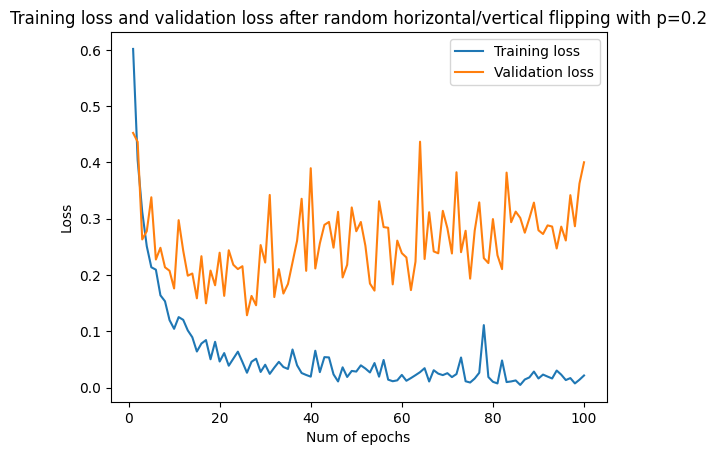

In [22]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

#defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_path_IT2= './trained_model/image_trans_flipping/model_rand_flip_p20.pth'

#training and validating
print('Starting training...')
model, train_loss_IT2, val_loss_IT2, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_p20, val_loader)
torch.save(model.state_dict(), model_path_IT2)
print('Model saved!')

#plotting losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_IT2, label='Training loss')
plt.plot(x, val_loss_IT2, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss after random horizontal/vertical flipping with p=0.2')
plt.savefig('./images/image_trans_flipping/training_val_loss_random_flipping_p20.png')
plt.show()

dict = {'train_loss': train_loss_IT2, 'val_loss_' : val_loss_IT2}
df = pd.DataFrame(dict)
df.to_csv('./csv/image_trans_flipping//training_val_loss_random_flipping_p20.csv')



Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 0.5664482116699219
Epoch [1/100], Batch No: [125], Loss: 0.37148892879486084
Validating...
The Current Loss: 0.531668309122324
Epoch [2/100], Batch No: [100], Loss: 0.5238542556762695
Epoch [2/100], Batch No: [125], Loss: 0.39385923743247986
Validating...
The Current Loss: 0.4657913111150265
Epoch [3/100], Batch No: [100], Loss: 0.533909022808075
Epoch [3/100], Batch No: [125], Loss: 0.31228047609329224
Validating...
The Current Loss: 0.4158194297924638
Epoch [4/100], Batch No: [100], Loss: 0.3362290561199188
Epoch [4/100], Batch No: [125], Loss: 0.3890100121498108
Validating...
The Current Loss: 0.38072673697024584
Epoch [5/100], Batch No: [100], Loss: 0.32394924759864807
Epoch [5/100], Batch No: [125], Loss: 0.31557345390319824
Validating...
The Current Loss: 0.372291998937726
Epoch [6/100], Batch No: [100], Loss: 0.1988808512687683
Epoch [6/100], Batch No: [125], Loss: 0.3919218182563782
Vali

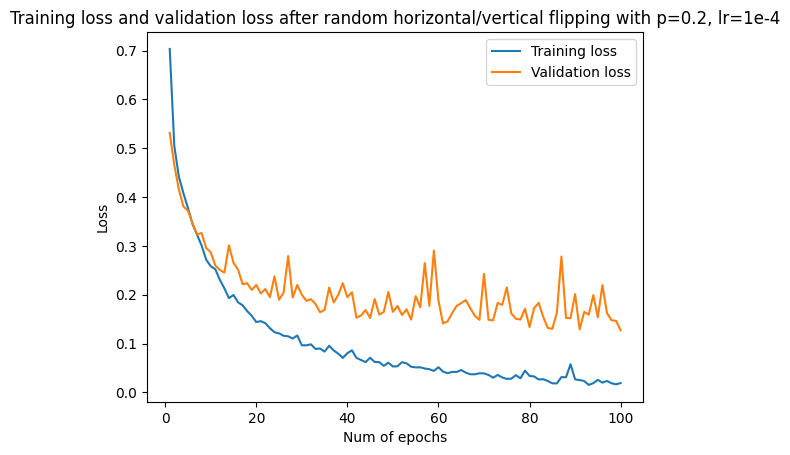

In [23]:
# based on above graph, validation loss oscillate quite badly as compared to the training loss. Which could be due to the learning rate being too high
# hence, another method to do could be to decrease the learning rate by another 10 fold or 100 fold to observe the difference in validation loss oscillation. 

# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding 
torch.manual_seed(123)

#defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_path_IT2_lr1= './trained_model/learning_rate_tuning/model_random_flip_p20_1e-4.pth'

#training and validating
print('Starting training and validating...')
model, train_loss_IT2_lr1, val_loss_IT2_lr1, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_p20, val_loader)
torch.save(model.state_dict(), model_path_IT2_lr1)
print('Model saved!')

#plotting losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_IT2_lr1, label='Training loss')
plt.plot(x, val_loss_IT2_lr1, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss after random horizontal/vertical flipping with p=0.2, lr=1e-4')
plt.savefig('./images/learning_rate_tuning/training_val_loss_random_flip_p20_lr1e-4.png')

plt.show()

#save losses to csv
dict = {'train_loss': train_loss_IT2_lr1, 'val_loss_' : val_loss_IT2_lr1}
df = pd.DataFrame(dict)
df.to_csv('./csv/learning_rate_tuning/training_val_loss_random_flip_p20_lr1e-4.csv')




Using device: mps
Starting training...
Epoch [1/100], Batch No: [100], Loss: 0.9597083926200867
Epoch [1/100], Batch No: [125], Loss: 0.8328952789306641
Validating...
The Current Loss: 0.9096738323569298
Epoch [2/100], Batch No: [100], Loss: 0.8149255514144897
Epoch [2/100], Batch No: [125], Loss: 0.6332215666770935
Validating...
The Current Loss: 0.6868749372661114
Epoch [3/100], Batch No: [100], Loss: 0.7670295238494873
Epoch [3/100], Batch No: [125], Loss: 0.5579644441604614
Validating...
The Current Loss: 0.6158310417085886
Epoch [4/100], Batch No: [100], Loss: 0.5722312331199646
Epoch [4/100], Batch No: [125], Loss: 0.5403254628181458
Validating...
The Current Loss: 0.5603026133030653
Epoch [5/100], Batch No: [100], Loss: 0.5614579916000366
Epoch [5/100], Batch No: [125], Loss: 0.4998989701271057
Validating...
The Current Loss: 0.537387803196907
Epoch [6/100], Batch No: [100], Loss: 0.3763009011745453
Epoch [6/100], Batch No: [125], Loss: 0.6007629632949829
Validating...
The Curre

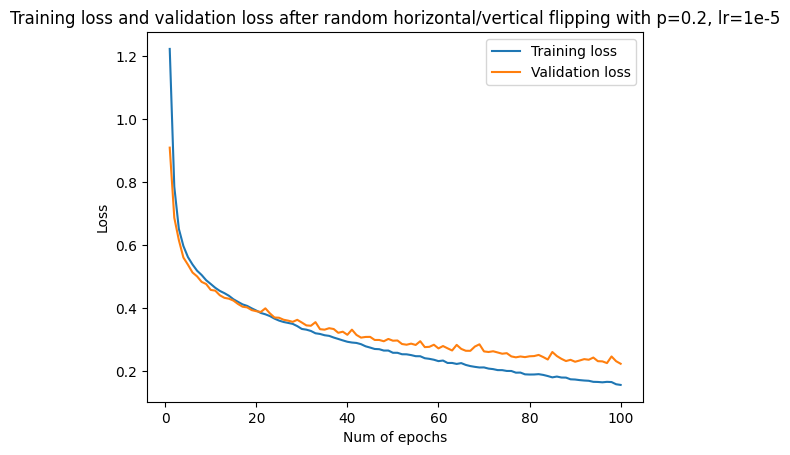

In [24]:
# based on above graph, validation loss oscillate quite badly as compared to the training loss. Which could be due to the learning rate being too high
# hence, another method to do could be to decrease the learning rate by another 10 fold or 100 fold to observe the difference in validation loss oscillation. 

# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

#defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model_path_IT2_lr2= './trained_model/learning_rate_tuning/model_random_flip_p20_1e-5.pth'

#training and validating
print('Starting training...')
model, train_loss_IT2_lr2, val_loss_IT2_lr2, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_p20, val_loader)
torch.save(model.state_dict(), model_path_IT2_lr2)
print('Model saved!')

#plotting losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_IT2_lr2, label='Training loss')
plt.plot(x, val_loss_IT2_lr2, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.title('Training loss and validation loss after random horizontal/vertical flipping with p=0.2, lr=1e-5')
plt.legend(loc='best')
plt.savefig('./images/learning_rate_tuning/training_val_loss_random_flip_p20_lr1e-5.png')


plt.show()

dict = {'train_loss': train_loss_IT2_lr2, 'val_loss_' : val_loss_IT2_lr2}
df = pd.DataFrame(dict)
df.to_csv('./csv/learning_rate_tuning/training_val_loss_random_flip_p20_lr1e-5.csv')




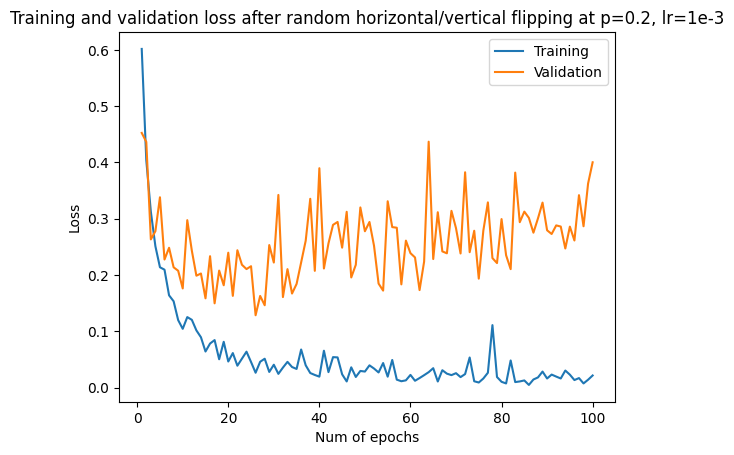

In [25]:
# replot the graph for lr = 1e-3 and random flipping at p=0.2

df = pd.read_csv('./csv/image_trans_flipping/training_val_loss_random_flipping_p20.csv')
training_loss, val_loss = df.train_loss, df.val_loss_
x = [i for i in range(1,101)]

plt.plot(x, training_loss, label = 'Training')
plt.plot(x, val_loss, label='Validation')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training and validation loss after random horizontal/vertical flipping at p=0.2, lr=1e-3')
plt.savefig('./images/learning_rate_tuning/training_val_loss_random_flip_p20_lr1e-3.png')
plt.show()

# Comparing learning rate effect on validation loss

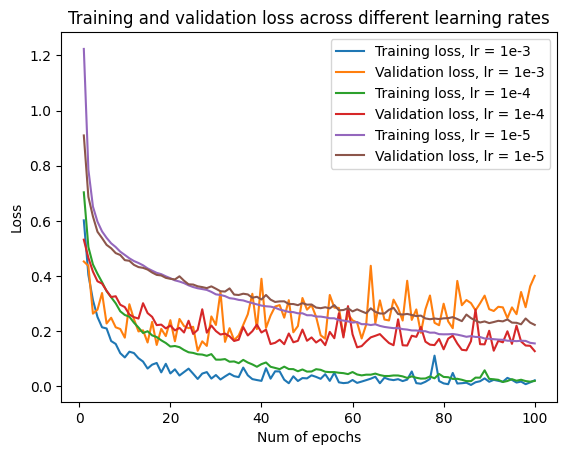

In [30]:
x = [i for i in range(1,101)]
for i in [3,4,5]:
    data_path = f'./csv/learning_rate_tuning/training_val_loss_random_flip_p20_lr1e-{i}.csv'
    df = pd.read_csv(data_path)
    train_loss, val_loss = df.train_loss, df.val_loss_
    plt.plot(x, train_loss, label=f'Training loss, lr = 1e-{i}')
    plt.plot(x, val_loss, label=f'Validation loss, lr = 1e-{i}')

plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training and validation loss across different learning rates')
plt.savefig('./images/learning_rate_tuning/Training_and_valdiation_losses_across_different_learning_rate_diff.png')

# Result from adjusting learning rate

The oscillation frequency died down when the learning rate decreases to 1e-5. Validation loss can be seen to smooth converged with training loss. However, one draw back is that it need to run for more epochs to lower down the loss which is a risk that we are willing to take here. Hence, from there on, the lr used will be 1e-5

Using device: mps
Starting training...
Epoch [1/100], Batch No: [100], Loss: 0.9580259323120117
Epoch [1/100], Batch No: [125], Loss: 0.8277753591537476
Validating...
The Current Loss: 0.9125222451984882
Epoch [2/100], Batch No: [100], Loss: 0.8125039339065552
Epoch [2/100], Batch No: [125], Loss: 0.6365544199943542
Validating...
The Current Loss: 0.6879662908613682
Epoch [3/100], Batch No: [100], Loss: 0.7712607979774475
Epoch [3/100], Batch No: [125], Loss: 0.5520968437194824
Validating...
The Current Loss: 0.6171002611517906
Epoch [4/100], Batch No: [100], Loss: 0.5792721509933472
Epoch [4/100], Batch No: [125], Loss: 0.55394446849823
Validating...
The Current Loss: 0.5625888835638762
Epoch [5/100], Batch No: [100], Loss: 0.5591011047363281
Epoch [5/100], Batch No: [125], Loss: 0.4934501051902771
Validating...
The Current Loss: 0.5406031869351864
Epoch [6/100], Batch No: [100], Loss: 0.37843602895736694
Epoch [6/100], Batch No: [125], Loss: 0.6000701189041138
Validating...
The Curre

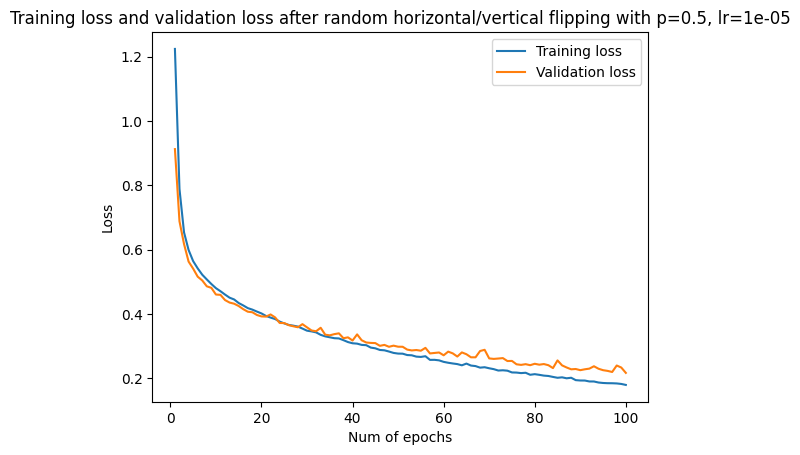

In [31]:
## choosing lr = 1e-05 as best lr to train 
## back to optimising the data by introducing randomness to data. previously was on p=0.2

# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

#defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model_path_IT2_p50= './trained_model/image_trans_flipping//model_random_flip_p50.pth'

#training and validating
print('Starting training...')
model, train_loss_IT2_p50, val_loss_IT2_p50, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_p50, val_loader)
torch.save(model.state_dict(), model_path_IT2_p50)
print('Model saved!')

#plotting losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_IT2_p50, label='Training loss')
plt.plot(x, val_loss_IT2_p50, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss after random horizontal/vertical flipping with p=0.5, lr=1e-05')
plt.savefig('./images/image_trans_flipping/training_val_loss_random_flip_p50_lr1e-05.png')

plt.show()

#saving losses as csv
dict = {'train_loss': train_loss_IT2_p50, 'val_loss_' : val_loss_IT2_p50}
df = pd.DataFrame(dict)
df.to_csv('./csv/image_trans_flipping//training_val_loss_random_flip_p50_lr1e-05.csv')



Using device: mps
Starting training...
Epoch [1/100], Batch No: [100], Loss: 0.966055691242218
Epoch [1/100], Batch No: [125], Loss: 0.8402647972106934
Validating...
The Current Loss: 0.9123820029199123
Epoch [2/100], Batch No: [100], Loss: 0.8178387880325317
Epoch [2/100], Batch No: [125], Loss: 0.6394788026809692
Validating...
The Current Loss: 0.6864399071782827
Epoch [3/100], Batch No: [100], Loss: 0.775133490562439
Epoch [3/100], Batch No: [125], Loss: 0.5518288612365723
Validating...
The Current Loss: 0.6148680299520493
Epoch [4/100], Batch No: [100], Loss: 0.5723319053649902
Epoch [4/100], Batch No: [125], Loss: 0.5584417581558228
Validating...
The Current Loss: 0.5604143086820841
Epoch [5/100], Batch No: [100], Loss: 0.5635244250297546
Epoch [5/100], Batch No: [125], Loss: 0.4946385622024536
Validating...
The Current Loss: 0.5386096127331257
Epoch [6/100], Batch No: [100], Loss: 0.3742322325706482
Epoch [6/100], Batch No: [125], Loss: 0.5822850465774536
Validating...
The Curren

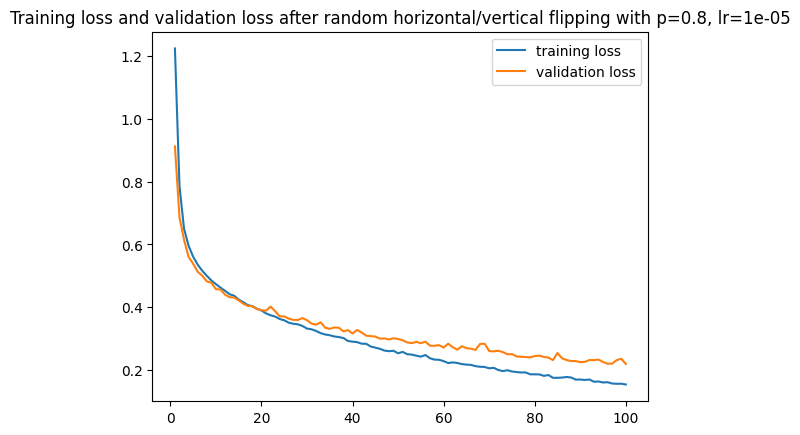

In [33]:
## choosing lr = 1e-05 as best lr to train 
## back to optimising the data by introducing randomness to data. previously was on p=0.2 and p=0.5

# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

#defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model_path_IT2_p80= './trained_model/image_trans_flipping/model_random_flip_p80_.pth'

# training and validating 
print('Starting training...')
model, train_loss_IT2_p80, val_loss_IT2_p80, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_p80, val_loader)
torch.save(model.state_dict(), model_path_IT2_p80)
print('Model saved!')

# plotting 
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_IT2_p80, label='training loss')
plt.plot(x, val_loss_IT2_p80, label='validation loss')
plt.title('Training loss and validation loss after random horizontal/vertical flipping with p=0.8, lr=1e-05')
plt.savefig('./images/image_trans_flipping/training_val_loss_random_flip_p80_lr1e-05.png')

plt.legend()
plt.show()

dict = {'train_loss': train_loss_IT2_p80, 'val_loss_' : val_loss_IT2_p80}
df = pd.DataFrame(dict)
df.to_csv('./csv/image_trans_flipping/training_val_loss_random_flip_p80_lr1e-05.csv')



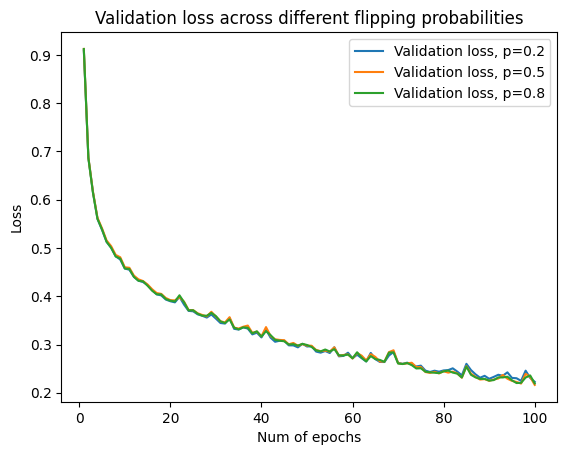

In [35]:
x = [i for i in range(1,101)]
for i in [2,5,8]:
    data_path = f'./csv/image_trans_flipping/training_val_loss_random_flip_p{i}0_lr1e-05.csv'
    df = pd.read_csv(data_path)
    train_loss, val_loss = df.train_loss, df.val_loss_
    #plt.plot(x, train_loss, label=f'Training loss, p=0.{i}')
    plt.plot(x, val_loss, label=f'Validation loss, p=0.{i}')

plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Validation loss across different flipping probabilities')
plt.savefig('./images/image_trans_flipping/Valdiation_losses_across_different_flip_prob.png')

# Comparing the validation loss and minimising oscillation

An overlapping plot of the validation loss curves at different learning rates show that lr = 0.00001 gives least oscillation, due to the ever smaller change in the gradient during each backpropagation step. As such, we will be using this learning rate in training an optimised model. 

| Probability | 0.2 | 0.5 | 0.8
| --- | --- | --- | ---
|  | 0.223 | 0.216 | 0.219

Based on above table, it can be seen that 20% and 80% probability of randomly flipping the data gives about the same loss. With p50 yielding the lowest loss, hence, we will be using p50. 

# Step 6: Stride of max pooling layer tuning 
The stride value can be seen as the step parameter of the kernel movement across an image array. A greater stride value contributes to dimension reducibility. Generally, a smaller stride result in smaller dimension reduction and vice versa.

In [39]:
# build model for testing 

#build models
# model architecture, stride = 3, 4, 5 

class CNNMaxPoolingStride(nn.Module):
    def __init__(self, stride):
        super(CNNMaxPoolingStride, self).__init__()
        self.layer3 = nn.Sequential(
            nn.Conv2d(3,6,3),
            nn.ReLU(),
            nn.MaxPool2d(5,3),
            nn.Conv2d(6,16,3),
            nn.ReLU(),
            nn.MaxPool2d(5,3),
            nn.Flatten(),
            nn.Linear(16*12*12, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(3,6,3),
            nn.ReLU(),
            nn.MaxPool2d(5,4),
            nn.Conv2d(6,16,3),
            nn.ReLU(),
            nn.MaxPool2d(5,4),
            nn.Flatten(),
            nn.Linear(16*7*7, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(3,6,3),
            nn.ReLU(),
            nn.MaxPool2d(5,5),
            nn.Conv2d(6,16,3),
            nn.ReLU(),
            nn.MaxPool2d(5,5),
            nn.Flatten(),
            nn.Linear(16*4*4, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.stride = stride
    def forward(self, x):
        if self.stride == 3:
            x_3 = self.layer3(x)
            return x_3 
        elif self.stride == 4:
            x_4 = self.layer4(x)
            return x_4
        elif self.stride == 5:
            x_5 = self.layer5(x)
            return x_5

model = CNNMaxPoolingStride(3)
print(model)

CNNMaxPoolingStride(
  (layer3): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
  (layer4): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=5, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=784, out_features=64, bias=True)
    (8): ReLU()

In [40]:
#load data

# for image transformation

#load dataset 
# load in dataset with transformation
import numpy as np 
import torchvision
import torchvision.transforms as transforms

# for color images, mean and std obtained above 
mean_c = np.array([0.7276, 0.5982, 0.8760])
std_c = np.array([0.1381, 0.1791, 0.0721])


transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])


train_dataset_stride = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_train)
val_dataset_stride = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/val', transform=transform_test)
test_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_test)

train_loader_stride = torch.utils.data.DataLoader(train_dataset_stride, batch_size=32, shuffle=True, num_workers=4)
val_loader_stride = torch.utils.data.DataLoader(val_dataset_stride, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 1.4833498001098633
Epoch [1/100], Batch No: [125], Loss: 1.4672675132751465
Validating...
The Current Loss: 1.4333581775426865
Epoch [2/100], Batch No: [100], Loss: 1.234937310218811
Epoch [2/100], Batch No: [125], Loss: 1.1816091537475586
Validating...
The Current Loss: 1.2072099819779396
Epoch [3/100], Batch No: [100], Loss: 1.044160008430481
Epoch [3/100], Batch No: [125], Loss: 0.9504361152648926
Validating...
The Current Loss: 0.9935183674097061
Epoch [4/100], Batch No: [100], Loss: 0.903019368648529
Epoch [4/100], Batch No: [125], Loss: 0.7878744006156921
Validating...
The Current Loss: 0.8437900803983212
Epoch [5/100], Batch No: [100], Loss: 0.7586628198623657
Epoch [5/100], Batch No: [125], Loss: 0.7499474883079529
Validating...
The Current Loss: 0.7463608719408512
Epoch [6/100], Batch No: [100], Loss: 0.6014071106910706
Epoch [6/100], Batch No: [125], Loss: 0.7539241313934326
Validating

ValueError: x and y must have same first dimension, but have shapes (400,) and (100,)

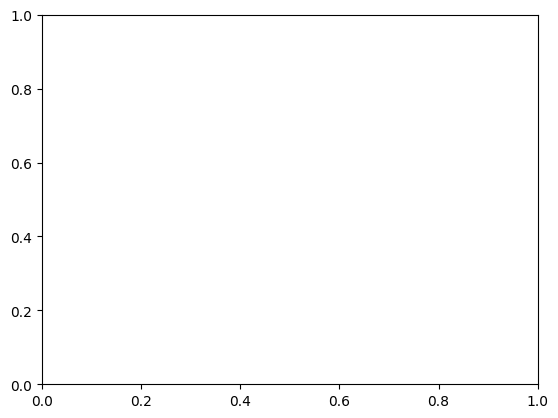

In [41]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

#defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNNMaxPoolingStride(3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model_path_stride3= './trained_model/mp_stride_tuning/model_stride_3.pth'

#training and validating
print('Starting training and validating...')
model, train_loss_stride3, val_loss_stride3, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader_stride, val_loader_stride)
torch.save(model.state_dict(), model_path_stride3)
print('Model saved!')

#plotting losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,401)]
plt.plot(x, train_loss_stride3, label='Training loss')
plt.plot(x, val_loss_stride3, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.title('Training loss and validation loss with max pooling stride of 3')
plt.legend(loc='best')
plt.savefig('./images/mp_stride_tuning/training_val_loss_mp_stride_3.png')
plt.show()

#saving losses as csv
dict = {'train_loss': train_loss_stride3, 'val_loss_' : val_loss_stride3}
df = pd.DataFrame(dict)
df.to_csv('./csv/mp_stride_tuning/training_val_loss_mp_stride_3.csv')



Plotting training loss and validation loss over number of epochs


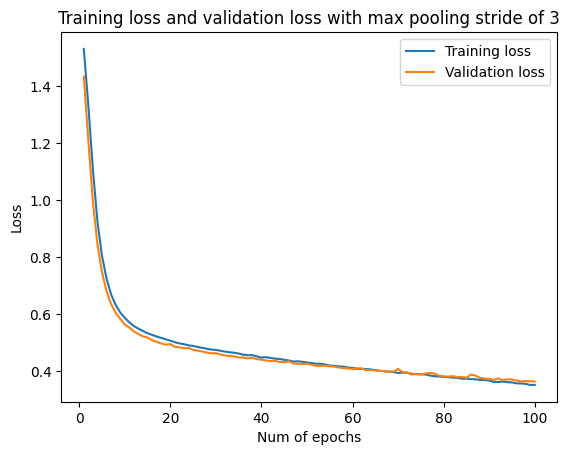

In [42]:
#re-plotting losses for above error
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_stride3, label='Training loss')
plt.plot(x, val_loss_stride3, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.title('Training loss and validation loss with max pooling stride of 3')
plt.legend(loc='best')
plt.savefig('./images/mp_stride_tuning/training_val_loss_mp_stride_3.png')
plt.show()

#saving losses as csv
dict = {'train_loss': train_loss_stride3, 'val_loss_' : val_loss_stride3}
df = pd.DataFrame(dict)
df.to_csv('./csv/mp_stride_tuning/training_val_loss_mp_stride_3.csv')

Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 1.5146174430847168
Epoch [1/100], Batch No: [125], Loss: 1.5506858825683594
Validating...
The Current Loss: 1.5209196880459785
Epoch [2/100], Batch No: [100], Loss: 1.410292148590088
Epoch [2/100], Batch No: [125], Loss: 1.4225608110427856
Validating...
The Current Loss: 1.4324374347925186
Epoch [3/100], Batch No: [100], Loss: 1.369093894958496
Epoch [3/100], Batch No: [125], Loss: 1.3081218004226685
Validating...
The Current Loss: 1.3297953680157661
Epoch [4/100], Batch No: [100], Loss: 1.2597278356552124
Epoch [4/100], Batch No: [125], Loss: 1.1676924228668213
Validating...
The Current Loss: 1.2235161922872066
Epoch [5/100], Batch No: [100], Loss: 1.2086265087127686
Epoch [5/100], Batch No: [125], Loss: 1.1114332675933838
Validating...
The Current Loss: 1.1222301349043846
Epoch [6/100], Batch No: [100], Loss: 0.955647349357605
Epoch [6/100], Batch No: [125], Loss: 1.075188398361206
Validating.

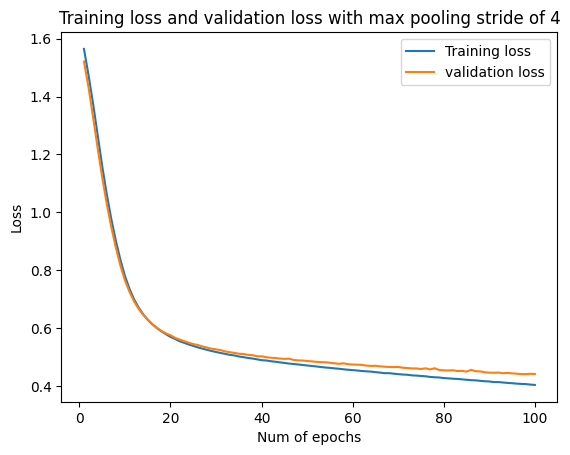

In [44]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

# defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNNMaxPoolingStride(4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model_path_stride4= './trained_model/mp_stride_tuning/model_stride_4.pth'

#training and validating
print('Starting training and validating...')
model, train_loss_stride4, val_loss_stride4, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader, val_loader)
torch.save(model.state_dict(), model_path_stride4)
print('Model saved!')

#plotting losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_stride4, label='Training loss')
plt.plot(x, val_loss_stride4, label='validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss with max pooling stride of 4')
plt.savefig('./images/mp_stride_tuning/training_val_loss_mp_stride_4.png')

plt.show()

#save losses to csv
dict = {'train_loss': train_loss_stride4, 'val_loss_' : val_loss_stride4}
df = pd.DataFrame(dict)
df.to_csv('./csv/mp_stride_tuning/training_val_loss_mp_stride_4.csv')



Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 1.5900657176971436
Epoch [1/100], Batch No: [125], Loss: 1.5507868528366089
Validating...
The Current Loss: 1.5764486640691757
Epoch [2/100], Batch No: [100], Loss: 1.539820909500122
Epoch [2/100], Batch No: [125], Loss: 1.5312285423278809
Validating...
The Current Loss: 1.533268854022026
Epoch [3/100], Batch No: [100], Loss: 1.5084902048110962
Epoch [3/100], Batch No: [125], Loss: 1.4646861553192139
Validating...
The Current Loss: 1.4855106696486473
Epoch [4/100], Batch No: [100], Loss: 1.453020691871643
Epoch [4/100], Batch No: [125], Loss: 1.4175487756729126
Validating...
The Current Loss: 1.4299933686852455
Epoch [5/100], Batch No: [100], Loss: 1.4167735576629639
Epoch [5/100], Batch No: [125], Loss: 1.3273730278015137
Validating...
The Current Loss: 1.367668204009533
Epoch [6/100], Batch No: [100], Loss: 1.265944242477417
Epoch [6/100], Batch No: [125], Loss: 1.3220278024673462
Validating..

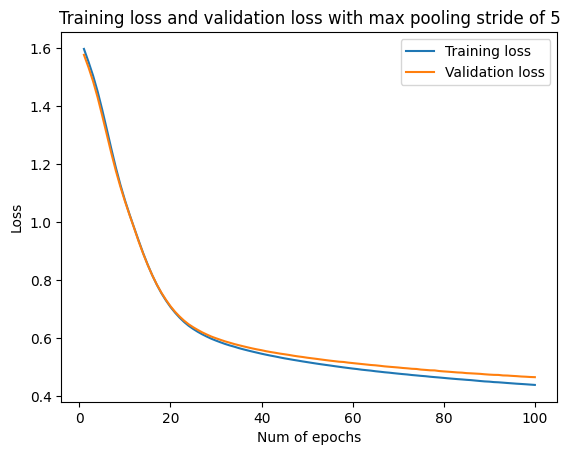

In [45]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

# defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNNMaxPoolingStride(5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model_path_stride5= './trained_model/mp_stride_tuning/model_mp_stride_5.pth'

# training and validating
print('Starting training and validating...')
model, train_loss_stride5, val_loss_stride5, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader, val_loader)
torch.save(model.state_dict(), model_path_stride5)
print('Model saved!')

# plotting losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_stride5, label='Training loss')
plt.plot(x, val_loss_stride5, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss with max pooling stride of 5')
plt.savefig('./images/mp_stride_tuning/training_val_loss_mp_stride_5.png')

plt.show()

#save losses as csv
dict = {'train_loss': train_loss_stride5, 'val_loss_' : val_loss_stride5}
df = pd.DataFrame(dict)
df.to_csv('./csv/mp_stride_tuning/training_val_loss_mp_stride_5.csv')



# Comparison between different strides for max pooling
A graph showing the validation losses and training losses using different strides is plotted

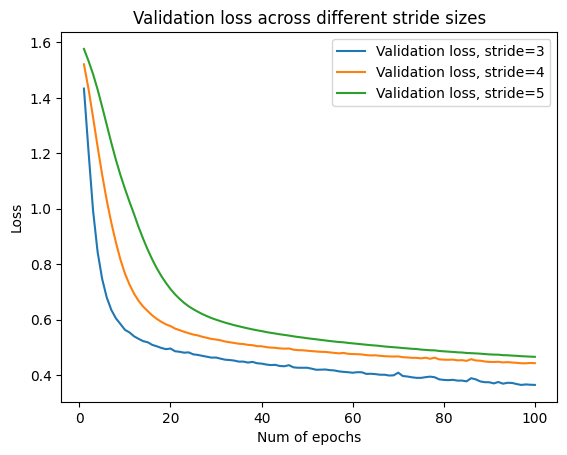

In [47]:
x = [i for i in range(1,101)]
for i in [3,4,5]:
    data_path = f'./csv/mp_stride_tuning/training_val_loss_mp_stride_{i}.csv'
    df = pd.read_csv(data_path)
    train_loss, val_loss = df.train_loss, df.val_loss_
    #plt.plot(x, train_loss, label=f'Training loss, stride={i}')
    plt.plot(x, val_loss, label=f'Validation loss, stride={i}')

plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Validation loss across different stride sizes')
plt.savefig('./images/mp_stride_tuning/valdiation_losses_across_different_stride_sizes.png')

# Conclusion after comparing strides of max pooling filter 

|Stride|Loss|
| --- | --- | 
| 3 | 0.364 |
| 4 | 0.442 |
| 5 | 0.466 |

Based on above chart, stride of 3 gives the lowest loss after training at 100 epochs. As such, stride of 3 will be used in final model.

# Step 7: Tuning of number of filters/feature maps from conv2d layers 
This comparison is between the differences in the number of filters for each of the convolutional layers. The values 8, 16, 32 and 16, 32, 64 will be tested. Generally higher feature map size = more extracted features but that may also lead to over fitting. Hence, this step is to figure out what is the best balance of accuracy and fit.

In [3]:
# build model
import torch 
import torch.nn as nn

class CNNLayer(nn.Module):
    def __init__(self, layer):
        super(CNNLayer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,8,3),
            nn.ReLU(),
            nn.MaxPool2d(5,3),
            nn.Conv2d(8,16,3),
            nn.ReLU(),
            nn.MaxPool2d(5,3),
            nn.Flatten(),
            nn.Linear(16*12*12, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(5,3),
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(5,3),
            nn.Flatten(),
            nn.Linear(32*12*12, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

        self.layer = layer 
    def forward(self, x):
        if self.layer == 1:
            x_1 = self.layer1(x)
            return x_1 
        elif self.layer == 2:
            x_2 = self.layer2(x)
            return x_2


model = CNNLayer(1)
print(model)

CNNLayer(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
  (layer2): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4608, out_features=64, bias=True)
    (8): ReLU()
    (9)

In [4]:
#load dataset 
# load in dataset with transformation
import numpy as np 
import torchvision
import torchvision.transforms as transforms

# for color images, mean and std obtained above 
mean_c = np.array([0.7276, 0.5982, 0.8760])
std_c = np.array([0.1381, 0.1791, 0.0721])


transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])


train_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/train', transform=transform_train)
val_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/val', transform=transform_test)
test_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/hps/test', transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 1.4672062397003174
Epoch [1/100], Batch No: [125], Loss: 1.3920711278915405
Validating...
The Current Loss: 1.3751442953944206
Epoch [2/100], Batch No: [100], Loss: 1.1869542598724365
Epoch [2/100], Batch No: [125], Loss: 1.061715841293335
Validating...
The Current Loss: 1.1252314411103725
Epoch [3/100], Batch No: [100], Loss: 0.8816534280776978
Epoch [3/100], Batch No: [125], Loss: 1.0087825059890747
Validating...
The Current Loss: 0.9291051588952541
Epoch [4/100], Batch No: [100], Loss: 0.9726822972297668
Epoch [4/100], Batch No: [125], Loss: 0.6937156319618225
Validating...
The Current Loss: 0.8002600967884064
Epoch [5/100], Batch No: [100], Loss: 0.7898672819137573
Epoch [5/100], Batch No: [125], Loss: 0.7529170513153076
Validating...
The Current Loss: 0.7179417535662651
Epoch [6/100], Batch No: [100], Loss: 0.6519646644592285
Epoch [6/100], Batch No: [125], Loss: 0.7851806282997131
Validati

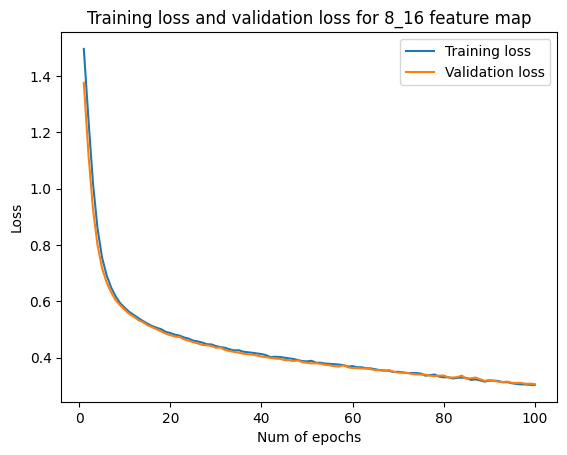

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

# defining parameters of train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNNLayer(1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model_path_8_16= './trained_model/no_feature_map_tuning/model_8_16.pth'

#training and validating
print('Starting training and validating...')
model, train_loss_816, val_loss_816, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader, val_loader)
torch.save(model.state_dict(), model_path_8_16)
print('Model saved!')

#plotting losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_816, label='Training loss')
plt.plot(x, val_loss_816, label='Validation loss') 
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss for 8_16 feature map')
plt.savefig('./images/no_feature_map_tuning/training_val_loss_8_16_feature_map.png')

plt.show()

dict = {'train_loss': train_loss_816, 'val_loss_' : val_loss_816}
df = pd.DataFrame(dict)
df.to_csv('./csv/no_feature_map_tuning/training_val_loss_8_16_feature_map.csv')



Using device: mps
Starting training and validating...
Epoch [1/100], Batch No: [100], Loss: 1.2457175254821777
Epoch [1/100], Batch No: [125], Loss: 1.131452202796936
Validating...
The Current Loss: 1.1051105223596096
Epoch [2/100], Batch No: [100], Loss: 0.8912132978439331
Epoch [2/100], Batch No: [125], Loss: 0.6644007563591003
Validating...
The Current Loss: 0.7873064912855625
Epoch [3/100], Batch No: [100], Loss: 0.6153000593185425
Epoch [3/100], Batch No: [125], Loss: 0.7321904301643372
Validating...
The Current Loss: 0.6717829145491123
Epoch [4/100], Batch No: [100], Loss: 0.8163970708847046
Epoch [4/100], Batch No: [125], Loss: 0.49099665880203247
Validating...
The Current Loss: 0.6199944447726011
Epoch [5/100], Batch No: [100], Loss: 0.6138390898704529
Epoch [5/100], Batch No: [125], Loss: 0.6661194562911987
Validating...
The Current Loss: 0.5914705600589514
Epoch [6/100], Batch No: [100], Loss: 0.5138117074966431
Epoch [6/100], Batch No: [125], Loss: 0.7245692014694214
Validat

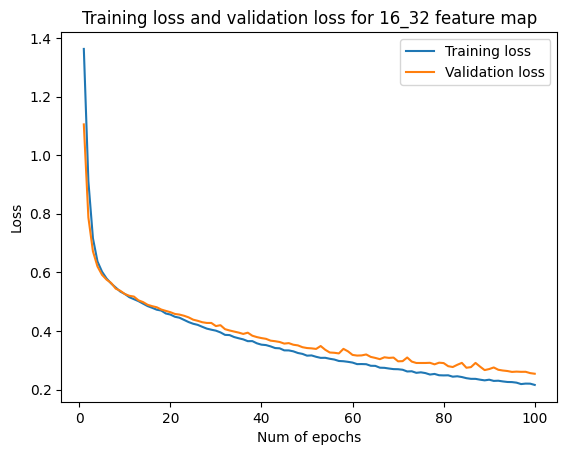

In [8]:
# GPU device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

#seeding
torch.manual_seed(123)

#defining parameters for train function
epochs = 100
loss_function = nn.CrossEntropyLoss()
model = CNNLayer(2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model_path_16_32= './trained_model/no_feature_map_tuning/model_16_32.pth'

#training and validating
print('Starting training and validating...')
model, train_loss_1632, val_loss_1632, = train_no_early_stop(device, model, epochs, optimizer, loss_function, train_loader, val_loader)
torch.save(model.state_dict(), model_path_16_32)
print('Model saved!')

#plotting losses
print('Plotting training loss and validation loss over number of epochs')
x = [i for i in range(1,101)]
plt.plot(x, train_loss_1632, label='Training loss')
plt.plot(x, val_loss_1632, label='Validation loss')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training loss and validation loss for 16_32 feature map')
plt.savefig('./images/no_feature_map_tuning/training_val_loss_16_32_feature_map.png')
plt.show()

#saving losses to csv
dict = {'train_loss': train_loss_1632, 'val_loss_' : val_loss_1632}
df = pd.DataFrame(dict)
df.to_csv('./csv/no_feature_map_tuning/training_val_loss_16_32_feature_map.csv')



# Comparison of validation and training losses between different number of feature maps

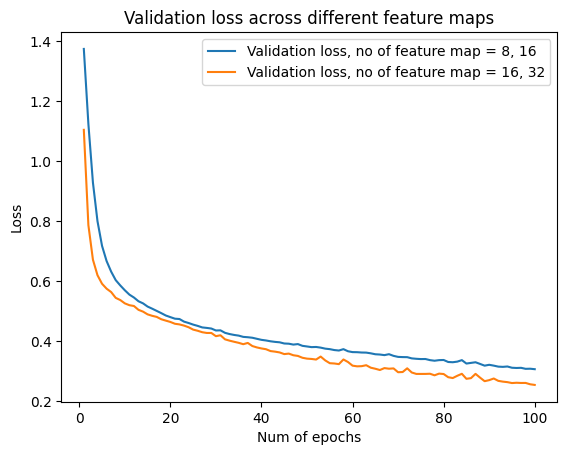

In [10]:
x = [i for i in range(1,101)]
for a,b in [(8,16), (16,32)]:
    data_path = f'./csv/no_feature_map_tuning/training_val_loss_{a}_{b}_feature_map.csv'
    df = pd.read_csv(data_path)
    train_loss, val_loss = df.train_loss, df.val_loss_
    #plt.plot(x, train_loss, label=f'Training loss, no of feature map = {a}, {b}')
    plt.plot(x, val_loss, label=f'Validation loss, no of feature map = {a}, {b}')

plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Validation loss across different feature maps')
plt.savefig('./images/no_feature_map_tuning/Valdiation_losses_across_different_feature_maps.png')

# Feature map input size 

Based on the overlapping set of validation loss plots, the 16, 32 feature map provides the lower loss. 

# Final model 

```
FinalCNN(
  (layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4608, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
)
```

In [3]:
# build model
import torch
import torch.nn as nn

class FinalCNN(nn.Module):
    def __init__(self):
        super(FinalCNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(5,3),
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(5,3),
            nn.Flatten(),
            nn.Linear(32*12*12, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
    def forward(self, x):
        x = self.layer(x)
        return x

model = FinalCNN()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total params: {pytorch_total_params}')
print(model)

Total params: 300389
FinalCNN(
  (layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4608, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [ ]:
# split the 25k images to train, test, split folder. 
# Raw folder contains the 25k images, 5k for each classes. With split-folder package, the dataset will be splitted
# to 80% --> train, 10% --> validation, 10% --> test and be stored in the processed folder. 
 
import splitfolders

splitfolders.ratio('./data_for_proj/raw/final/', output='./data_for_proj/processed/final', seed = 1337, ratio=(.8,.1, .1))

In [ ]:
import os 

size_of_train_folders = {'class_0': len(os.listdir('./data_for_proj/processed/final/train/colon_aca')),
                    'class_1': len(os.listdir('./data_for_proj/processed/final/train/colon_n')),
                    'class_2': len(os.listdir('./data_for_proj/processed/final/train/lung_aca')),
                    'class_3': len(os.listdir('./data_for_proj/processed/final/train/lung_n')),
                    'class_4': len(os.listdir('./data_for_proj/processed/final/train/lung_scc'))
}

size_of_val_folders = {'class_0': len(os.listdir('./data_for_proj/processed/final/val/colon_aca')),
                    'class_1': len(os.listdir('./data_for_proj/processed/final/val/colon_n')),
                    'class_2': len(os.listdir('./data_for_proj/processed/final/val/lung_aca')),
                    'class_3': len(os.listdir('./data_for_proj/processed/final/val/lung_n')),
                    'class_4': len(os.listdir('./data_for_proj/processed/final/val/lung_scc'))
}


size_of_test_folders = {'class_0': len(os.listdir('./data_for_proj/processed/final/test/colon_aca')),
                    'class_1': len(os.listdir('./data_for_proj/processed/final/test/colon_n')),
                    'class_2': len(os.listdir('./data_for_proj/processed/final/test/lung_aca')),
                    'class_3': len(os.listdir('./data_for_proj/processed/final/test/lung_n')),
                    'class_4': len(os.listdir('./data_for_proj/processed/final/test/lung_scc'))
}


print(f'size of train folders: {size_of_train_folders}')
print(f'size of val folders: {size_of_val_folders}')
print(f'size of test folders: {size_of_test_folders}')

In [24]:
# load data 
# load in dataset with transformation
import numpy as np 
import torchvision
import torchvision.transforms as transforms

# for color images, mean and std obtained above 
mean_c = np.array([0.7276, 0.5982, 0.8760])
std_c = np.array([0.1381, 0.1791, 0.0721])


transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])

transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_c), torch.Tensor(std_c))
])


train_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/final/train', transform=transform_train)
val_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/final/val', transform=transform_test)
test_dataset = torchvision.datasets.ImageFolder(root='./data_for_proj/processed/final/test', transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [33]:
# Train
def train_with_early_stop(device, model, epochs, optimizer, loss_function, 
                            train_loader, valid_loader, patience, previous_val_loss,
                            checkpoint_path, final_model_path):   
    counter = 0 #set counter
    stop_training = False
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        model.train()
        batch_train_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            label = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            output = model(images)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()

            batch_train_loss += loss.item()
            
            # Show progress
            if (batch_idx+1)%100 == 0 or (batch_idx+1)==len(train_loader): 
                print (f'Epoch [{epoch+1}/{epochs}], Batch No: [{batch_idx+1}], Loss: {loss.item()}')
            
            
        avg_batch_train_loss = batch_train_loss/len(train_loader)
        train_loss.append(avg_batch_train_loss)

        # check validation loss
        print('Validating...')
        current_val_loss = validation(model, device, valid_loader, loss_function)
        print('The Current Loss:', current_val_loss)
        val_loss.append(current_val_loss)

        #earlystop
        if current_val_loss < previous_val_loss:
            print(f'Current validation loss value, {current_val_loss}, is less than the previous_val_loss {previous_val_loss}.')
            previous_val_loss = current_val_loss #update loss value
            print(f'Updating the previous validation loss as {previous_val_loss}.')
            counter = 0 #update counter 
            print(f'Current counter count = {counter}')
            print(f'Saving model as checkpoint...')
            torch.save(model.state_dict(), checkpoint_path) #saving model as checkpoint
            print('checkpoint saved')
        
        elif current_val_loss > previous_val_loss:
            print(f'Current validation loss, {current_val_loss} is greater than previous validation loss, {previous_val_loss}.')
            counter+=1
            print(f'Current counter count = {counter}')
            if counter == patience and counter == 1:
                print('Model did not meet the minimum loss value')
                print('Saving checkpoint as the only model available')
                torch.save(model.state_dict(), checkpoint_path)
                print('checkpoint saved')
                stop_training = True #stop training
            elif counter == patience:
                print(f'No improvement noted after {counter} consecutive epoch')
                print(f'Early stopping is triggered')
                stop_training = True #stop training
        

        if stop_training:
            break
   
    model.load_state_dict(torch.load(checkpoint_path)) #loading from checkpoint file
    return model, train_loss, val_loss


def validation(model, device, valid_loader, loss_function):
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = loss_function(output, labels)
            loss_total += loss.item()

    return loss_total / len(valid_loader)

def test(device, test_loader, model):
    model.eval()
    n_correct = 0
    n_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')



In [34]:
def main():
    # GPU device
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    print(f"Using device: {device}")
    torch.manual_seed(123)

    epochs = 1000
    learning_rate = 0.00001
    loss_function = nn.CrossEntropyLoss()
    model = FinalCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    patience = 20
    previous_val_loss = 20
    checkpoint_path ='./trained_model/finalCNN/checkpoint.pth'
    final_model_path ='./trained_model/finalCNN/final_model.pth'

    # Data
    trainloader = train_loader
    validloader = val_loader
    testloader = test_loader

    # Train and validate
    print('Starting training...')
    model, train_loss, val_loss = train_with_early_stop(device, model, epochs, optimizer, loss_function, trainloader, validloader, patience, previous_val_loss, checkpoint_path, final_model_path)
    print('Loading best checkpoint and saving it as final model...')
    torch.save(model.state_dict(), final_model_path)
    print('Model saved!')

    #save train loss and val loss
    loss = {'train loss': train_loss, 'val loss': val_loss}
    df = pd.DataFrame(loss)
    df.to_csv('./csv/finalCNN/final_model_train_val_loss.csv')

    #Testing
    print('Loading model')
    model.load_state_dict(torch.load(final_model_path))
    print('begin testing...')
    test(device, testloader, model)

    #plotting confusion matrix 


if __name__ == '__main__':
    main()

Using device: mps
Starting training...
Epoch [1/1000], Batch No: [100], Loss: 1.1842186450958252
Epoch [1/1000], Batch No: [200], Loss: 1.038388729095459
Epoch [1/1000], Batch No: [300], Loss: 0.6378850936889648
Epoch [1/1000], Batch No: [400], Loss: 0.5589569807052612
Epoch [1/1000], Batch No: [500], Loss: 0.5988165140151978
Epoch [1/1000], Batch No: [600], Loss: 0.5547662973403931
Epoch [1/1000], Batch No: [625], Loss: 0.5038148164749146
Validating...
The Current Loss: 0.5974775000086313
Current validation loss value, 0.5974775000086313, is less than the previous_val_loss 20.
Updating the previous validation loss as 0.5974775000086313.
Current counter count = 0
Saving model as checkpoint...
checkpoint saved
Epoch [2/1000], Batch No: [100], Loss: 0.461166113615036
Epoch [2/1000], Batch No: [200], Loss: 0.49276861548423767
Epoch [2/1000], Batch No: [300], Loss: 0.6104499697685242
Epoch [2/1000], Batch No: [400], Loss: 0.4992738366127014
Epoch [2/1000], Batch No: [500], Loss: 0.66409957

In [35]:
import pandas as pd 
import numpy
from sklearn.metrics import confusion_matrix
import torch


device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
torch.manual_seed(123)

testloader = test_loader
print('Loading model')
final_model_path ='./trained_model/finalCNN/final_model.pth'
model.load_state_dict(torch.load(final_model_path))
model.to(device)
print('begin testing...')
test(device, testloader, model)


y_true = []
y_pred = []
 
for data in testloader:
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())
 
  outputs=model(images)
 
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

  	
cf_matrix = confusion_matrix(y_true, y_pred)

class_names = ('colon_aca', 'colon_n', 'lung_aca', 'lung_n',
           'lung_scc')
 
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
print(dataframe)


Using device: mps
Loading model
begin testing...
Accuracy of the network: 99.84 %
           colon_aca  colon_n  lung_aca  lung_n  lung_scc
colon_aca        500        0         0       0         0
colon_n            0      500         0       0         0
lung_aca           1        0       499       0         0
lung_n             0        0         0     500         0
lung_scc           0        0         3       0       497


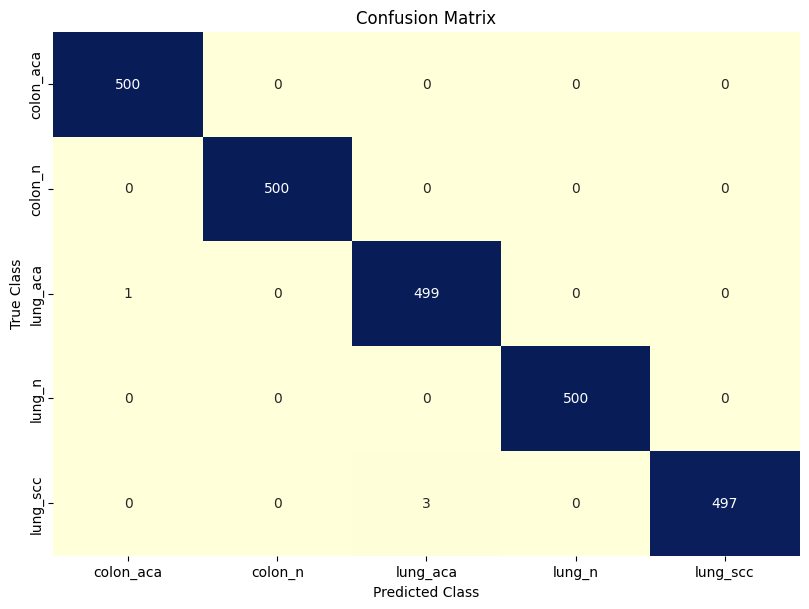

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       0.99      1.00      1.00       500
           3       1.00      1.00      1.00       500
           4       1.00      0.99      1.00       500

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



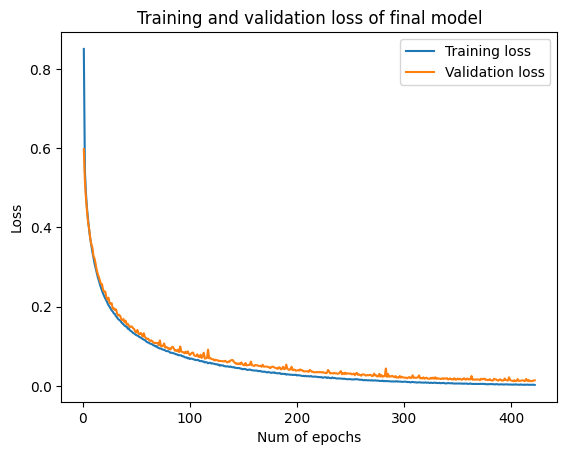

In [40]:
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv('./csv/finalCNN/final_model_train_val_loss.csv')
train_loss = df['train loss']
val_loss = df['val loss']
x = [i for i in range(1,423)]

plt.plot(x, train_loss, label='Training loss')
plt.plot(x, val_loss, label='Validation loss')
plt.title('Training and validation loss of final model')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig('./images/finalCNN/final_model_train_val_loss.png')
plt.show()

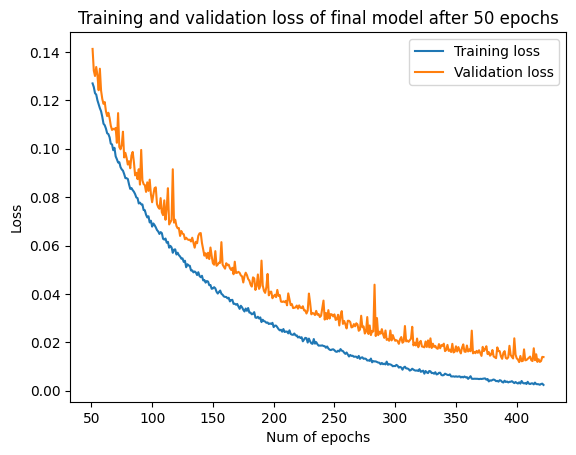

In [42]:
df = pd.read_csv('./csv/finalCNN/final_model_train_val_loss.csv')
train_loss = df['train loss']
val_loss = df['val loss']
x = [i for i in range(51,423)]

plt.plot(x, train_loss[50:], label='Training loss')
plt.plot(x, val_loss[50:], label='Validation loss')
plt.title('Training and validation loss of final model after 50 epochs')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig('./images/finalCNN/final_model_train_val_loss_after_50_epochs.png')
plt.show()